In [2]:
import pytesseract as pt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pdf2image import convert_from_path

In [3]:
def area(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x)-min(x))*(max(y)-min(y))

def start_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(y))

def end_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x),min(y))

def get_points(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(x),min(y),max(y))

def get_all_points(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
#                 cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return coordinates

def get_tables(image):
    coordinates = get_all_points(image)
#     print(len(coordinates))
    tables = []
    for coordinate in coordinates:
        tables.append(image[coordinate[2]:coordinate[3],coordinate[0]:coordinate[1]])
    return tables

def get_image_with_table(img):
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
                cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return image

In [ ]:
books_punjabi = sorted(['data_books/punjabi/'+book for book in os.listdir('data_books/punjabi/')])

In [3]:
book = 'data_books/punjabi/pp_kharif__pb_table.pdf'

In [4]:
images = convert_from_path(book,dpi=300)

In [5]:
tables = [get_tables(np.array(image)) for image in images]

In [ ]:
table_small = cv2.imread('table-small-2.png')
table_large = cv2.imread('table-large-2.png')

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(ass)

In [23]:
def get_cells_coordinates(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=15)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=15)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=40)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=40)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))
    
#     plt.imshow(vertical_horizontal_lines)
#     plt.show()

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    return vertical_horizontal_lines

def get_text_csv(bounding_boxes,image):
#     print(bounding_boxes)
    cols = len(np.unique(np.array(bounding_boxes)[:,0]))
    rows = len(np.unique(np.array(bounding_boxes)[:,1]))
    
    rows_start_points = sorted(np.unique(np.array(bounding_boxes)[:,1]))
    cols_start_points = sorted(np.unique(np.array(bounding_boxes)[:,0]))
    rows_end_points = sorted(np.unique(np.array(bounding_boxes)[:,1]+np.array(bounding_boxes)[:,3]))
    cols_end_points = sorted(np.unique(np.array(bounding_boxes)[:,0]+np.array(bounding_boxes)[:,2]))
    
    table = []
    for i in range(rows):
        table.append([])
        for j in range(cols):
            table[i].append(())

    for idx,box in enumerate(bounding_boxes):
        col_start, row_start, w, h = box
        row_end, col_end = row_start+h,col_start+w
        #     print(rows_start_points.index(row_start)-rows_end_points.index(row_end))
        for i in range(rows_start_points.index(row_start),rows_end_points.index(row_end)+1):
            for j in range(cols_start_points.index(col_start),cols_end_points.index(col_end)+1):
                table[i][j]=box
#                 print(i,j,idx)
#     display_cell(image,table[7][0])
    # text = []
    all_text = ''
    for idx,row in enumerate(table):
    #     text.append([])
        for cell in row:
#             print(cell)
            x, y, w, h = cell
            ocr_text = pt.image_to_string(image[y:y+h,x:x+w],config='--psm 6',
                                          lang='pan').replace('\n','').replace('\x0c','').replace('_','')
#             print(ocr_text)
            all_text = all_text+ocr_text+','
        #         text[idx].append(ocr_text)
        all_text=all_text+'\n'
    return all_text

In [ ]:
bounding_boxes = get_cells_coordinates(table_large)

In [5]:
def display_cell(image,bounding_box):
    x, y, w, h = bounding_box
    plt.imshow(image[y:y+h,x:x+w])
    print(pt.image_to_string(image[y:y+h,x:x+w],config='--psm 6 --oem 3',lang='pan'))

In [ ]:
plt.imsave('table-1cell.png',tables[210][0])

In [ ]:
ass = cv2.imread('table-1cell.png')

In [ ]:
bounding_boxes = get_cells_coordinates(ass)
ocr = get_text_tsv(bounding_boxes,ass)

In [ ]:
all_text = ''
for idx,table in enumerate(tables):
    all_text = all_text + f'page-{idx}\n'
    for curr in table:
        try:
            bounding_boxes = get_cells_coordinates(curr)
            ocr = get_text_csv(bounding_boxes,curr)
            all_text = all_text + ocr + '\n'
        except:
            continue
    all_text = all_text + '\n\n\n\n'

In [ ]:
output_file = 'data_books/ocr_punjabi/pp_kharifs_tables.txt'
f=open(output_file,'w')
f.write(all_text)
f.close()

In [ ]:
all_text = ''
for idx,table in enumerate(tables):
    all_text = all_text + f'page-{idx}\n'
    for curr in table:
        try:
            ocr = pt.image_to_string(curr,config='--psm 6',lang='pan')
            all_text = all_text + ocr + '\n'
        except:
            continue
    all_text = all_text + '\n\n\n\n'

In [ ]:
output_file = 'data_books/ocr_punjabi/pp_kharifs_notes.txt'
f=open(output_file,'w')
f.write(all_text)
f.close()

In [ ]:
plt.imshow(tables[5][0])

In [9]:
error_page = [5,6,9,11,12,13,14,20,22,23,24,29,30,32,33,39,41,49,50,59,60,62]
for i in range(len(error_page)):
    error_page[i]=error_page[i]-1
print(error_page)

[4, 5, 8, 10, 11, 12, 13, 19, 21, 22, 23, 28, 29, 31, 32, 38, 40, 48, 49, 58, 59, 61]


In [25]:
def get_cells_coordinates_include_verification(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=15)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=15)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=45)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=45)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    print(boundingBoxes[0][2:],(np.shape(image)[1],np.shape(image)[0]))
    if (boundingBoxes[0][2]==np.shape(image)[1] and np.shape(image)[0]==boundingBoxes[0][3]):
        print('same')
        return boundingBoxes[1:]
    if (np.shape(image)[1]-boundingBoxes[0][2]>200 or
              np.shape(image)[0]-boundingBoxes[0][3]>200):
        return boundingBoxes
    x = input()
    if (x=='n'):
        return boundingBoxes
    return boundingBoxes[1:]

In [41]:
image = '/home/pyrosama/Downloads/pp_kharif__pb_table-40_page-0001.jpg'
image = cv2.imread(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
img = cv2.bitwise_not(img)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

In [45]:
vertical_lines = cv2.erode(img, vertical_kernel, iterations=5)
vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=5)

In [62]:
horizontal_lines = cv2.erode(img, hor_kernel, iterations=10)
horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=10)

In [63]:
vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

In [64]:
thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))

In [79]:
contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
temp_bound_box = [cv2.boundingRect(c) for c in contours]
(contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
# boundingBoxes=[]
# for box in temp_bound_box:
# #         print(box)
#     boundingBoxes.append(box)
# print(boundingBoxes[0][2:],(np.shape(image)[1],np.shape(image)[0]))
# x = input()
# if (x==''):
#     boundingBoxes = boundingBoxes[1:]
# return boundingBoxes[1:]
# bounding_boxes[1:]
temp_bound_box=temp_bound_box[1:]

In [10]:
table_to_be_edited = [tables[i] for i in error_page]

In [11]:
all_text = ''
for idx,table in enumerate(table_to_be_edited):
    all_text = all_text + f'page-{error_page[idx]}\n'
    print(len(table))
    for curr in table:
        try:
            bounding_boxes = get_cells_coordinates_include_verification(curr)
            ocr = get_text_csv(bounding_boxes,curr)
            all_text = all_text + ocr + '\n'
            print(ocr)
        except:
            continue
    all_text = all_text + '\n\n\n\n'

2
(1654, 283) (1654, 283)

“ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),“ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),“ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),
ਨਾਈਟ੍ਰੋਜਨ,ਫ਼ਾਸਫ਼ੋਰਸ,ਪੋਟਾਸ਼,,ਡੀਏਪੀ,ਜਾਂ ਸਿੰਗਲ ਸੁਪਰਫਾਸਫੇਟ,ਮਿਊਰੇਟ ਆਫ਼ ਪੋਟਾਸ਼,
42,12,12,90,27,75,20,

(777, 125) (1649, 767)
n
ਜੈਵਿਕ ਖਾਦ,ਮਾਤਰਾ (ਟਨਪ੍ਰਤੀ ਏਕੜ),ਖਾਦ ਦੀ ਬਚਤ,
ਰੂੜੀ,6,16 ਕਿਲੋ ਨਾਈਟ੍ਰੋਜਨ (35 ਕਿਲੋ ਯੂਰੀਆ),
ਪ੍ਰੈਸਮੰਡ,6,25 ਕਿਲੋ ਨਾਈਟ੍ਰੋਜਨ (55 ਕਿਲੋ ਯੂਰੀਆ),
ਮੁਰਗੀਆਂ ਦੀ ਖਾਦ,2.5,25 ਕਿਲੋ ਨਾਈਟ੍ਰੋਜਨ (55 ਕਿਲੋ ਯੂਰੀਆ),
ਗੋਬਰ ਗੈਸ ਸਲੌਰੀ (ਸੁੱਕੀ),2.4,16 ਕਿਲੋ ਨਾਈਟ੍ਰੋਜਨ (35 ਕਿਲੋ ਯੂਰੀਆ),
ਪਰਾਲੀਚਾਰ,2.0,16 ਕਿਲੋ ਨਾਈਟ੍ਰੋਜਨ (35 ਕਿਲੋ ਯੂਰੀਆ)#,
ਹਰੀ ਖਾਦ,,25 ਕਿਲੋ ਨਾਈਟ੍ਰੋਜਨ ਤੱਤ (55 ਕਿਲੋ ਯੂਰੀਆ)##,
ਗਰਮੀ ਰੁੱਤ ਦੀ ਮੂੰਗੀ ਦੀ ਰਹਿੰਦ-ਖੂੰਹਦ,,16 ਕਿਲੋ ਨਾਈਟ੍ਰੋਜਨ (35 ਕਿਲੋ ਯੂਰੀਆ)##,

1
(1653, 352) (1653, 352)

ਕਿਸਮਾਂ,ਪਨੀਰੀ ਬੀਜਣ ਦਾ ਸਮਾਂ,ਲੁਆਈ ਦਾ ਸਮਾਂ,
ਪੰਜਾਬ ਬਾਸਮਤੀ 7, 5 ਅਤੇ ਪੂਸਾ ਬਾਸਮਤੀ1121, 1637 ਤੇ 1718,ਜੂਨ ਦਾ ਪਹਿਲਾ ਪੰਦਰ੍ਹਵਾੜਾ,ਜੁਲਾਈ ਦਾ ਪਹਿਲਾ ਪੰਦਰ੍ਹਵਾੜਾ,
ਸੀ ਐਸ ਆਰ 30 ਅਤੇ ਪੂਸਾ ਬਾਸਮਤੀ1509,ਜੂਨ ਦਾ ਦੂਜਾ ਪੰਦਰ੍ਹਵਾੜਾ,ਜੁਲਾਈ ਦਾ ਦੂਜਾ ਪੰਦਰ੍ਹਵਾੜਾ,

1
(1650, 501) (1650, 501)

ਜ਼


(154, 67) (154, 67)

੭,5,],,0,,0,
੭,5,],,0,,0,

(153, 67) (153, 67)

੭.,5,],

(206, 64) (210, 68)

(154, 67) (154, 67)

],2.,੭,੭,

(153, 67) (153, 67)

],23,੭,

(206, 64) (210, 68)

(154, 67) (154, 67)

322,322,322,ਰਿ,ਰਿ,
322,322,322,ਰਿ,ਰਿ,
322,322,322,ਰਿ,ਰਿ,
322,322,322,ਰਿ,ਰਿ,

(153, 67) (153, 67)

(206, 64) (210, 68)

(154, 67) (154, 67)

986.,986.,986.,986.,986.,986.,੨,੨,
986.,986.,986.,986.,986.,986.,੨,੨,
986.,986.,986.,986.,986.,986.,੨,੨,
986.,986.,986.,986.,986.,986.,੨,੨,
986.,986.,986.,986.,986.,986.,੨,੨,

(153, 67) (153, 67)

(206, 64) (210, 68)

ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,
ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,
ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,
ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,ਅੰਮ੍ਰਿਤਸਰ,

(154, 66) (154, 66)

ਪ,

(153, 66) (153, 66)

ਪ,

(297, 115) (297, 115)

(306, 115) (306, 115)

(337, 107) (371, 116)

(397, 107) (431, 116)

(209, 186) (209, 186)

1
(1657, 286) (1657, 286)

ਲਾਈਨਾਂ ਵਿਚਕਾਰਫ਼ਾਸਲਾ,ਪਹੀਏ ਦਾ ਅਕਾਰ (ਇੰਚਾਂ ਜਾਂ ਸੈਂਟੀਮੀਟਰ ਵਿੱਚ),ਪਹੀਏ ਦਾ ਅਕਾਰ (ਇੰਚਾਂ ਜ

In [ ]:
21 40

In [14]:
output_file = 'data_books/ocr_punjabi/pp_kharifs_tables_error_update.txt'
f=open(output_file,'w')
f.write(all_text)
f.close()

In [118]:
input_str = "3 4 5 10 11 12 13 14 16 17 18 20 21 22 23 24 25 26 27 32 33 35 40 48 54 55 61"
input_str = input_str.split()
error_page = [int(num) for num in input_str]

In [114]:
book = 'data_books/punjabi/pp_rabi_pbi_table.pdf'

In [115]:
images = convert_from_path(book,dpi=300)

In [116]:
tables = [get_tables(np.array(image)) for image in images]

In [119]:
table_to_be_edited = [tables[i] for i in error_page]

In [126]:
# all_text = ''
for idx,table in enumerate(table_to_be_edited):
    all_text = all_text + f'page-{error_page[idx]}\n'
#     print(len(table))
    if (len(table)>3):
        print(error_page[idx],len(table))
    else:
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr)
#                 ocr = get_text_csv(bounding_boxes,curr)
#                 all_text = all_text + ocr + '\n'
                print(ocr)
            except:
                continue
#     all_text = all_text + '\n\n\n\n'

(1650, 543) (1650, 543)
same
,ਆਮ ਨਾਮ,
ਡਾਇਜ਼ੀਪਾਮ,,
ਫ਼ੀਨੋਬਾਰਬੀਟੋਨ,ਗਾਰਡੀਨਲ,
ਡਾਈਮਰਕੈਪਰੋਲ,ਟੀਕਾ ਬਾਲ (ਨੌਲ ਫਾਰਮਾਂ),
ਪਾਮ,ਨੀਓਪਮ, ਪਾਮ, ਪੈਮਪਲਸ, ਪਾਮ-ਏ-ਕੋਰੀਆ,

(1650, 349) (1650, 349)
same
,ਆਮ ਨਾਮ,
ਡਾਇਜ਼ੀਪਾਮ,,
ਫ਼ੀਨੋਬਾਰਬੀਟੋਨ,ਗਾਰਡੀਨਲ,
ਡਾਈਮਰਕੈਪਰੋਲ,ਟੀਕਾ ਬਾਲ (ਨੌਲ ਫਾਰਮਾਂ),
ਪਾਮ,ਨੀਓਪਮ, ਪਾਮ, ਪੈਮਪਲਸ, ਪਾਮ-ਏ-ਕੋਰੀਆ,

(1649, 220) (1649, 220)
same
,ਆਮ ਨਾਮ,
ਡਾਇਜ਼ੀਪਾਮ,,
ਫ਼ੀਨੋਬਾਰਬੀਟੋਨ,ਗਾਰਡੀਨਲ,
ਡਾਈਮਰਕੈਪਰੋਲ,ਟੀਕਾ ਬਾਲ (ਨੌਲ ਫਾਰਮਾਂ),
ਪਾਮ,ਨੀਓਪਮ, ਪਾਮ, ਪੈਮਪਲਸ, ਪਾਮ-ਏ-ਕੋਰੀਆ,

(1645, 468) (1645, 468)
same
,ਆਮ ਨਾਮ,
ਡਾਇਜ਼ੀਪਾਮ,,
ਫ਼ੀਨੋਬਾਰਬੀਟੋਨ,ਗਾਰਡੀਨਲ,
ਡਾਈਮਰਕੈਪਰੋਲ,ਟੀਕਾ ਬਾਲ (ਨੌਲ ਫਾਰਮਾਂ),
ਪਾਮ,ਨੀਓਪਮ, ਪਾਮ, ਪੈਮਪਲਸ, ਪਾਮ-ਏ-ਕੋਰੀਆ,

(1654, 445) (1654, 445)
same
,ਆਮ ਨਾਮ,
ਡਾਇਜ਼ੀਪਾਮ,,
ਫ਼ੀਨੋਬਾਰਬੀਟੋਨ,ਗਾਰਡੀਨਲ,
ਡਾਈਮਰਕੈਪਰੋਲ,ਟੀਕਾ ਬਾਲ (ਨੌਲ ਫਾਰਮਾਂ),
ਪਾਮ,ਨੀਓਪਮ, ਪਾਮ, ਪੈਮਪਲਸ, ਪਾਮ-ਏ-ਕੋਰੀਆ,

(1107, 63) (1649, 1140)
,ਆਮ ਨਾਮ,
ਡਾਇਜ਼ੀਪਾਮ,,
ਫ਼ੀਨੋਬਾਰਬੀਟੋਨ,ਗਾਰਡੀਨਲ,
ਡਾਈਮਰਕੈਪਰੋਲ,ਟੀਕਾ ਬਾਲ (ਨੌਲ ਫਾਰਮਾਂ),
ਪਾਮ,ਨੀਓਪਮ, ਪਾਮ, ਪੈਮਪਲਸ, ਪਾਮ-ਏ-ਕੋਰੀਆ,

(1652, 308) (1652, 308)
same
,ਆਮ ਨਾਮ,
ਡਾਇਜ਼ੀਪਾਮ,,
ਫ਼ੀਨੋਬਾਰਬੀਟੋਨ,ਗਾਰਡੀਨਲ,
ਡਾਈਮਰਕੈਪਰੋਲ,ਟੀਕਾ ਬਾਲ (ਨੌਲ ਫਾਰਮਾਂ),
ਪਾਮ,ਨੀਓਪਮ, ਪਾਮ, ਪੈਮਪਲ

In [111]:
output_file = 'data_books/ocr_punjabi/pp_rabi_tables_error_update.txt'
f=open(output_file,'w')
f.write(all_text)
f.close()

In [7]:
book = 'data_books/punjabi/pp_veg_pbi_table.pdf'
images = convert_from_path(book,dpi=300)
tables = [get_tables(np.array(image)) for image in images]

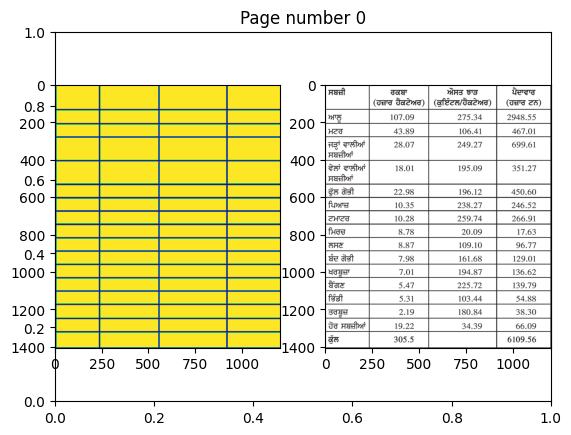

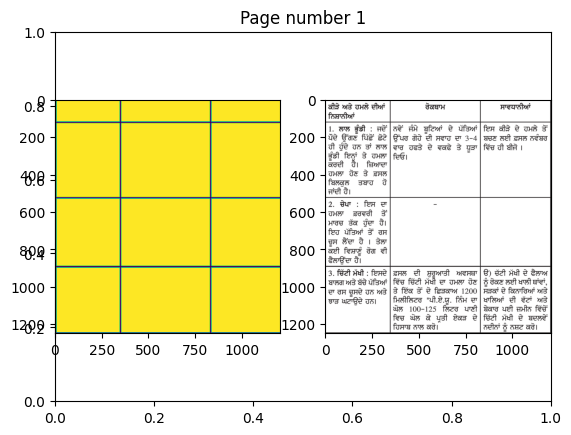

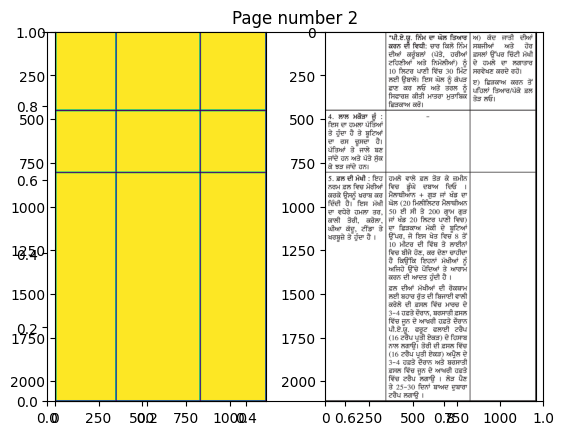

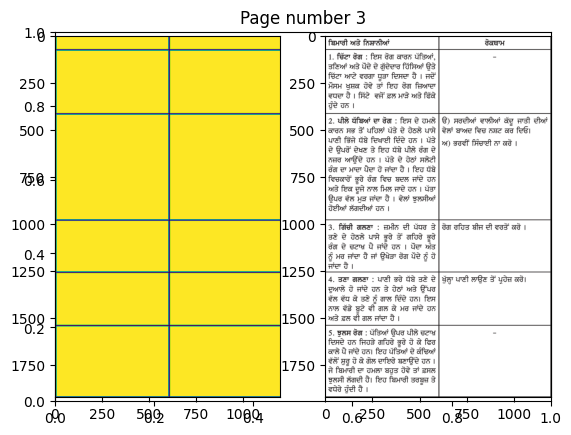

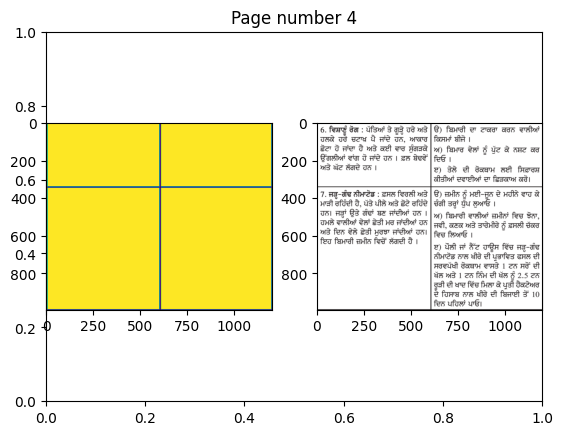

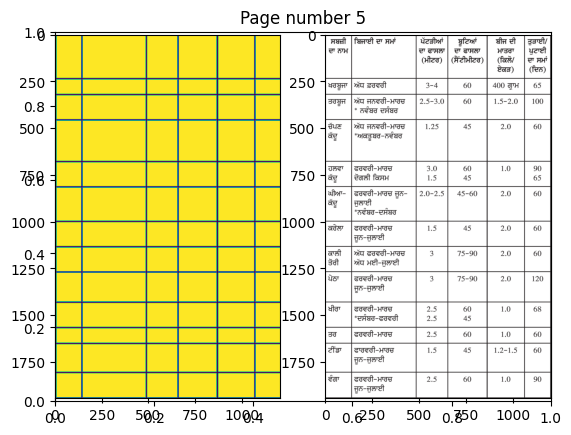

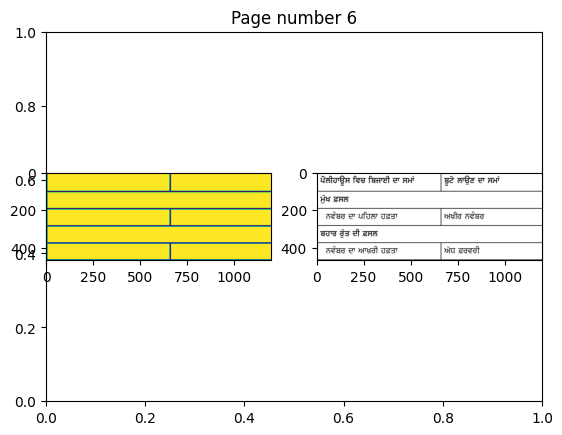

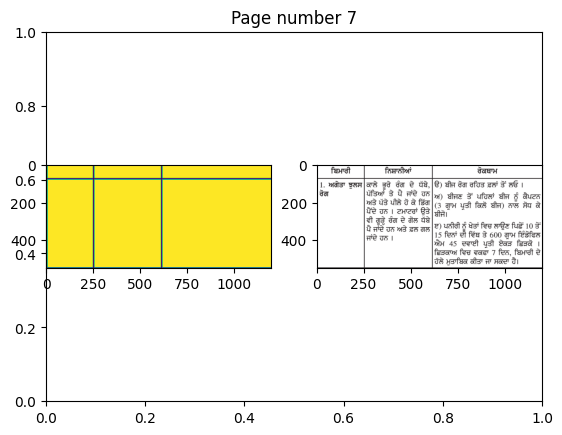

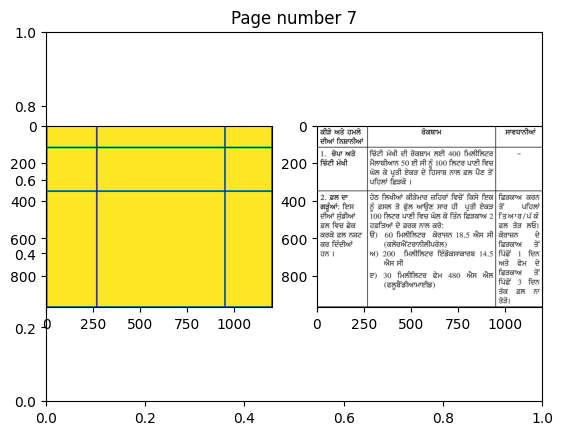

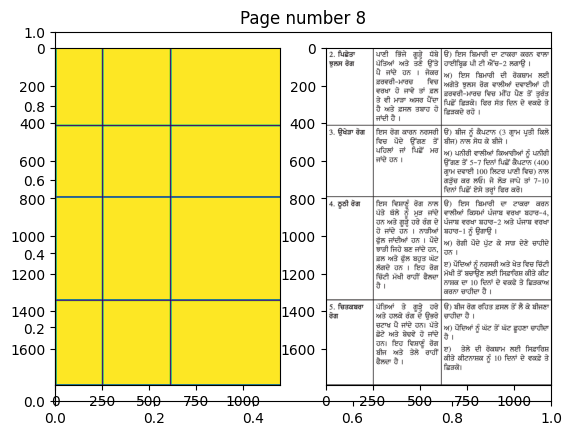

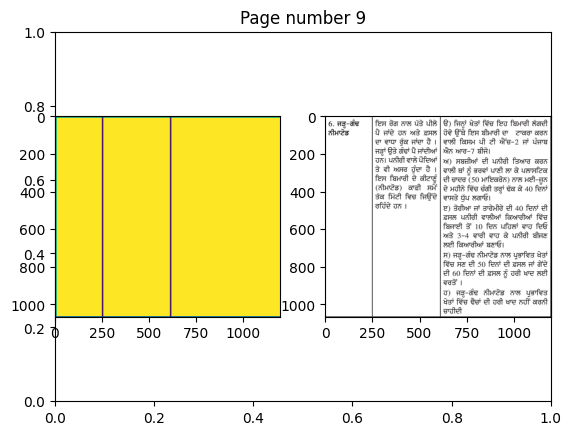

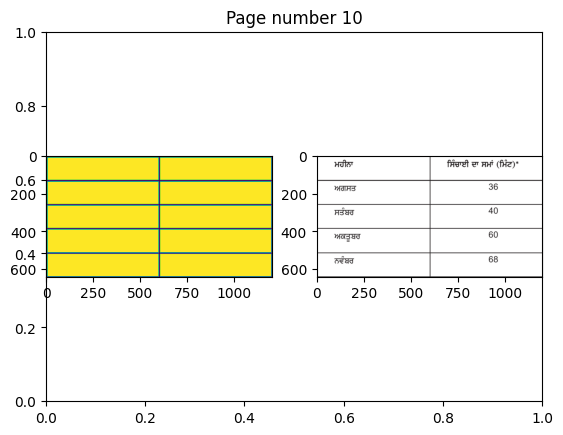

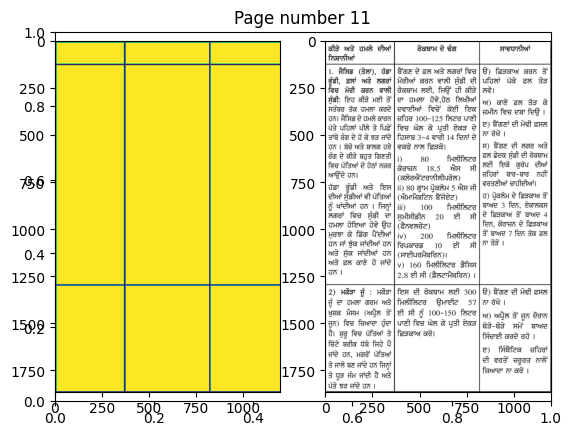

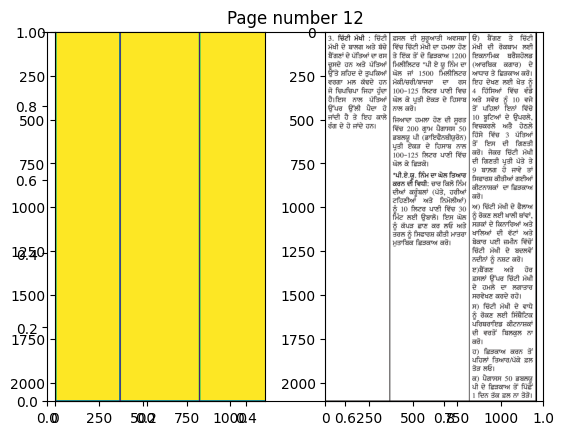

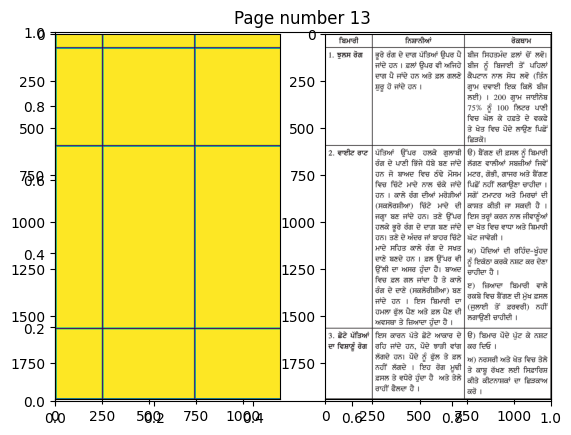

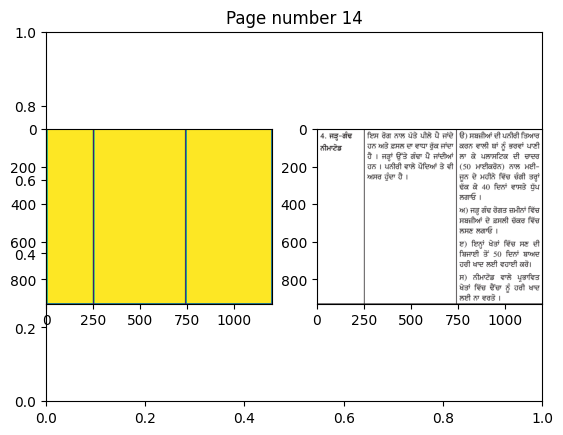

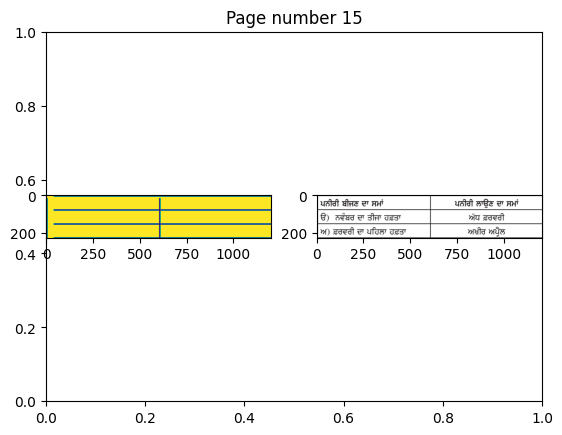

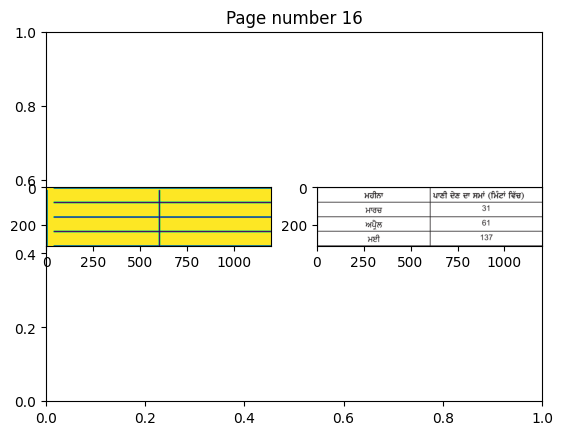

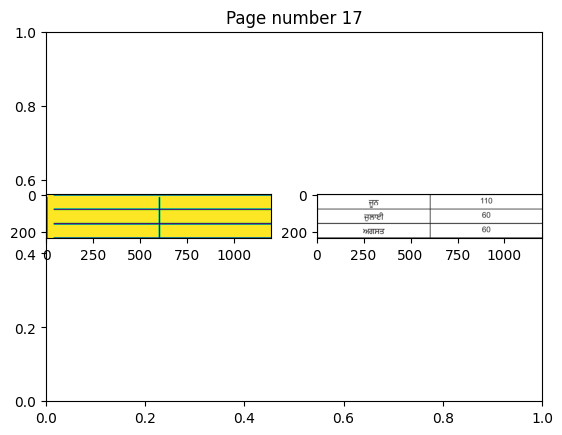

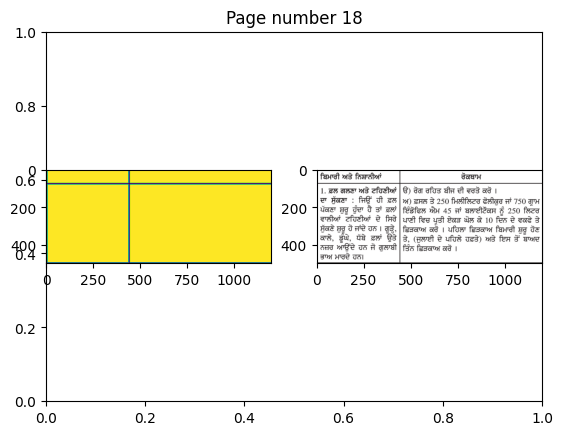

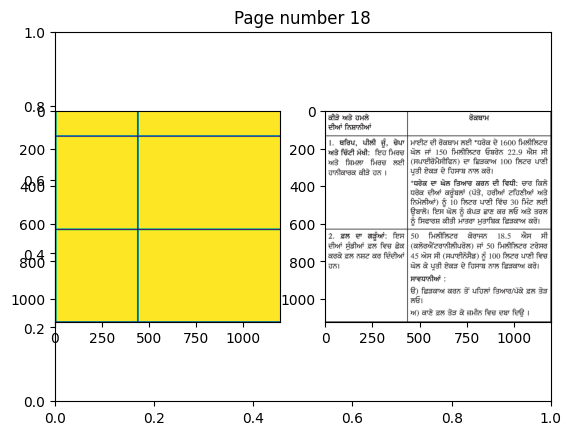

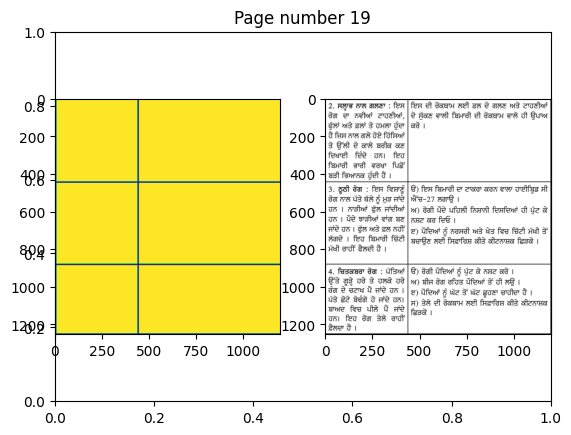

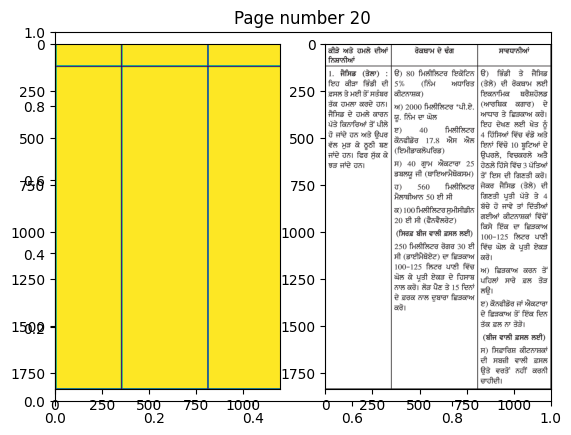

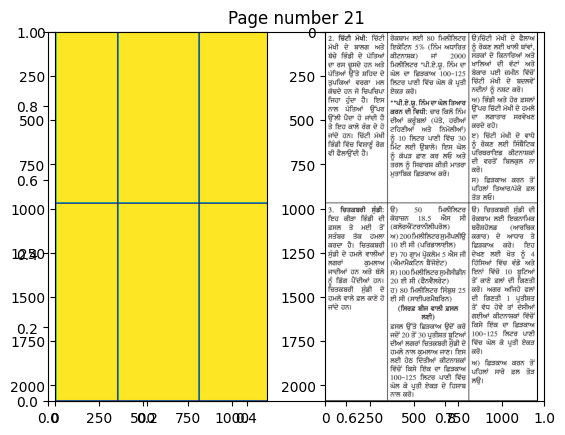

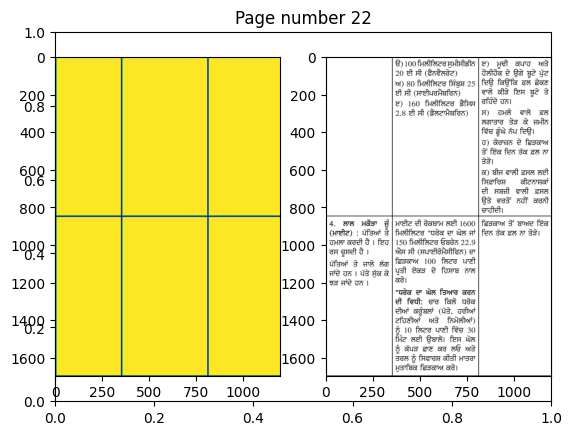

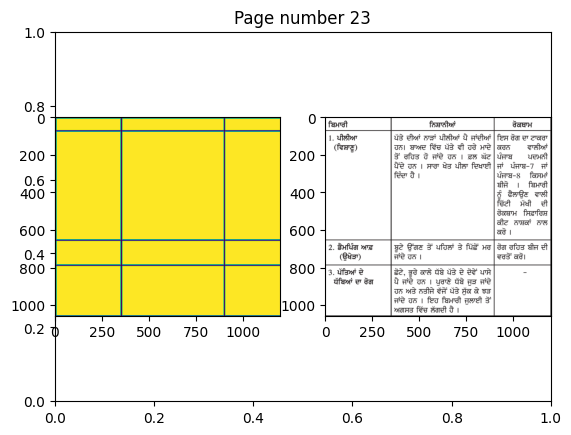

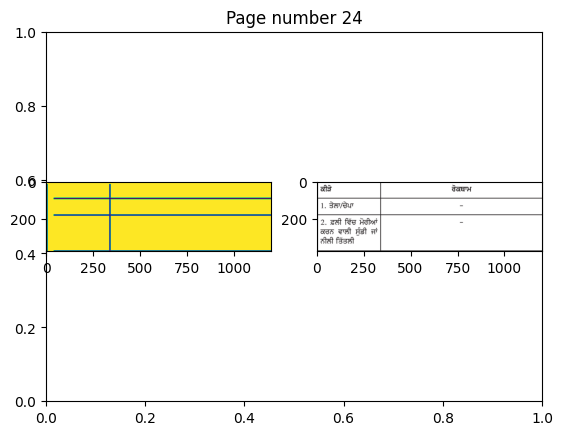

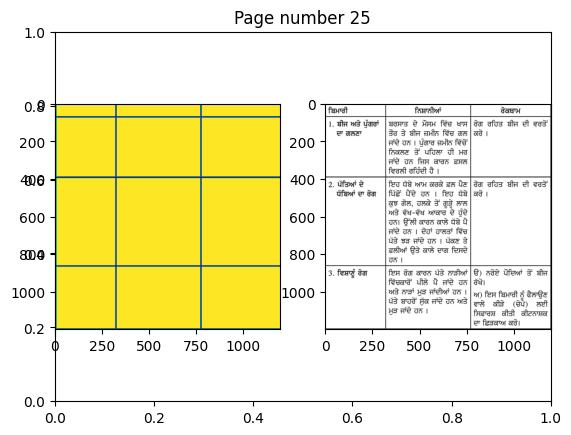

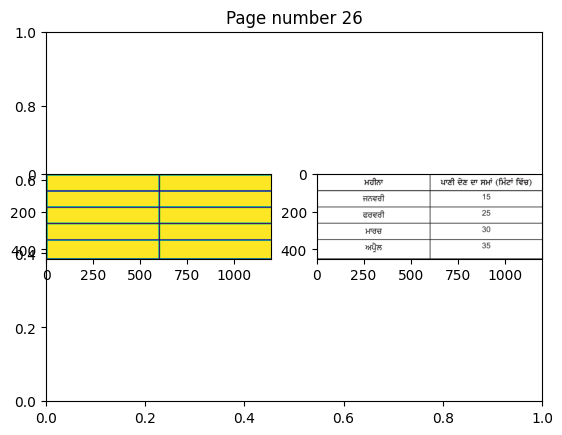

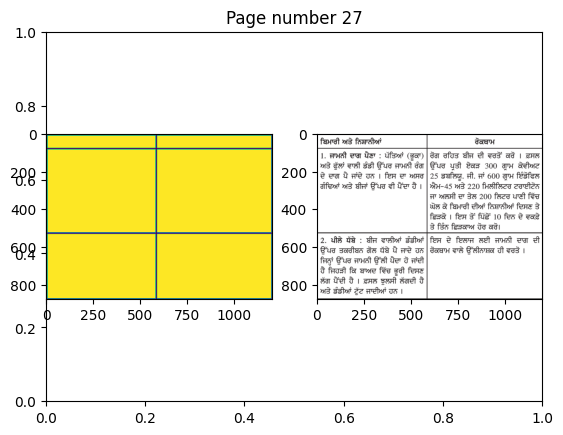

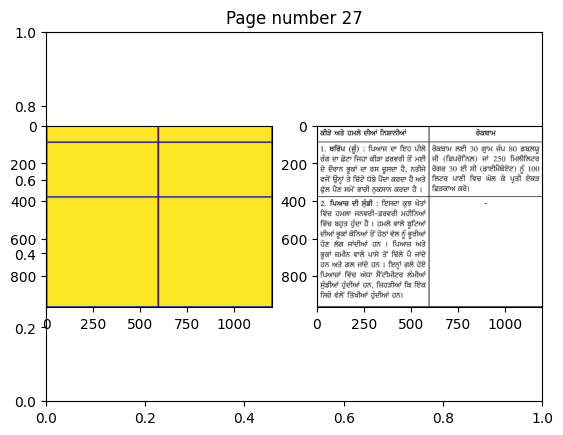

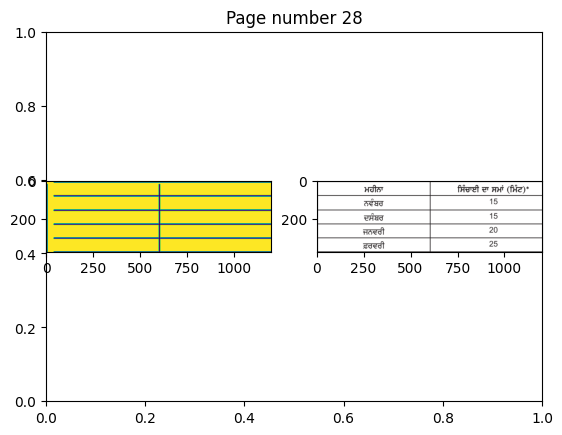

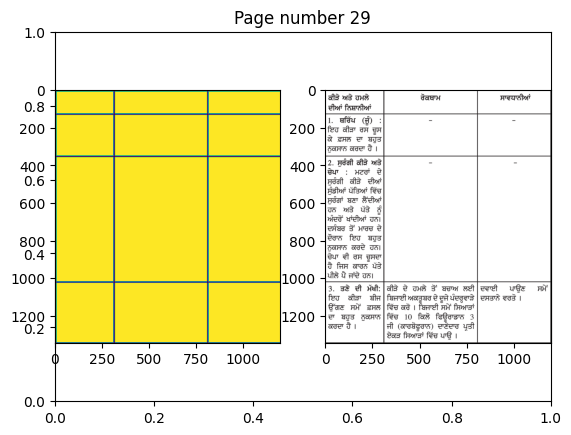

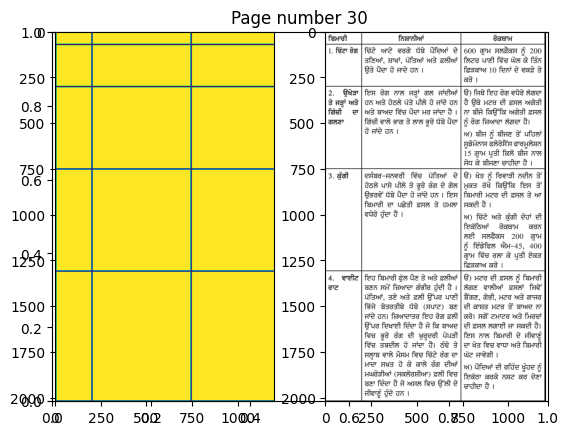

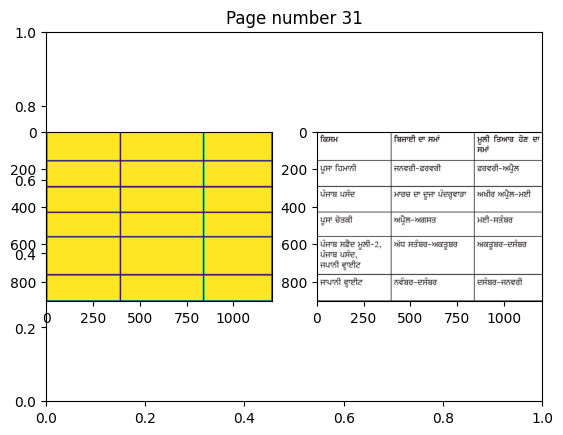

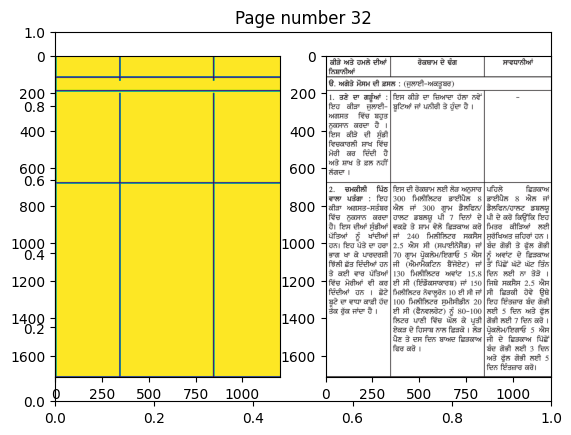

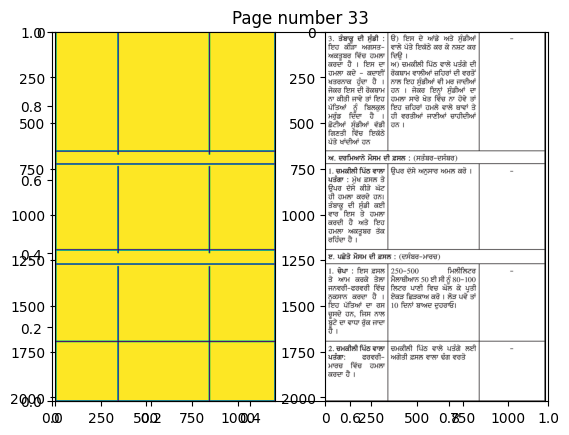

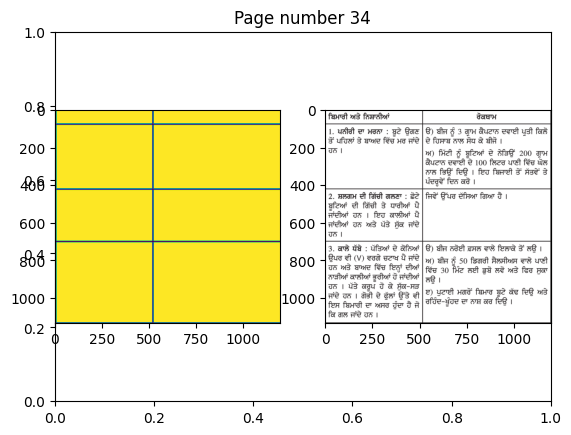

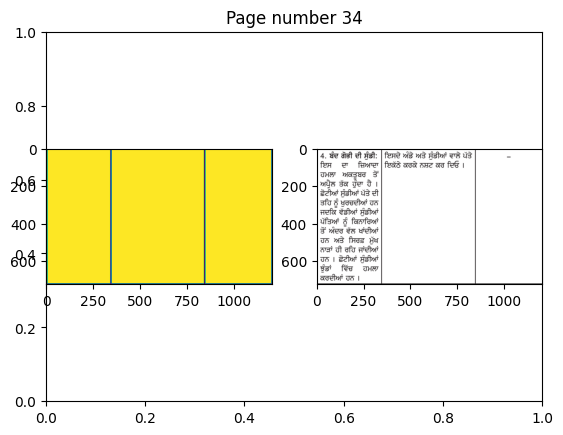

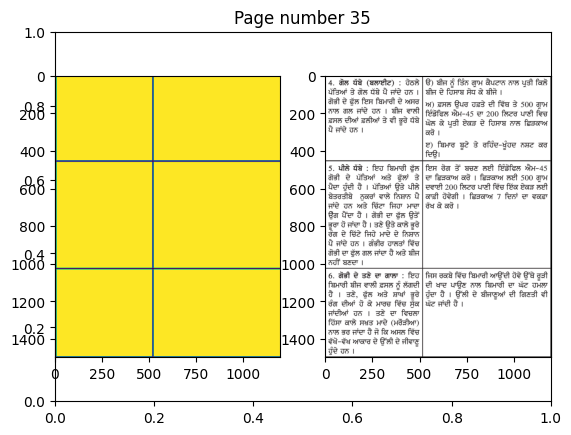

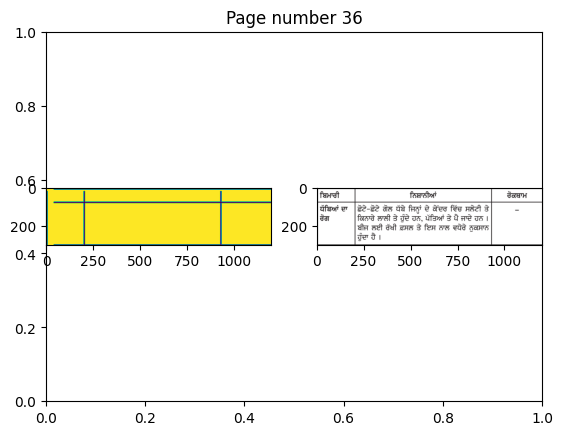

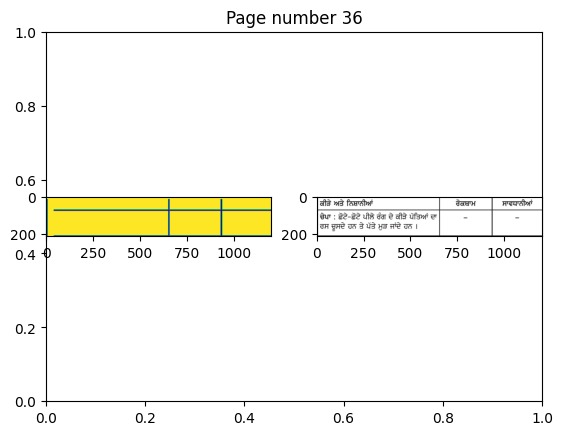

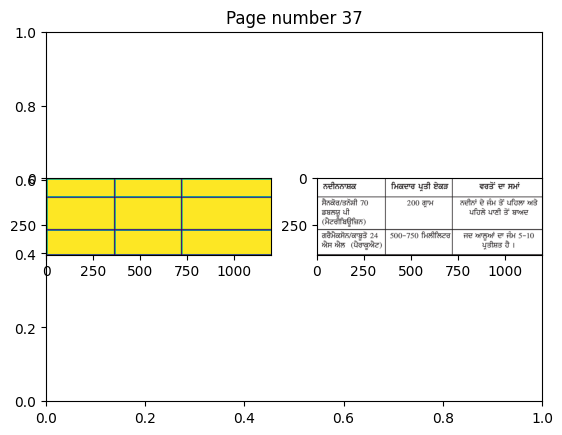

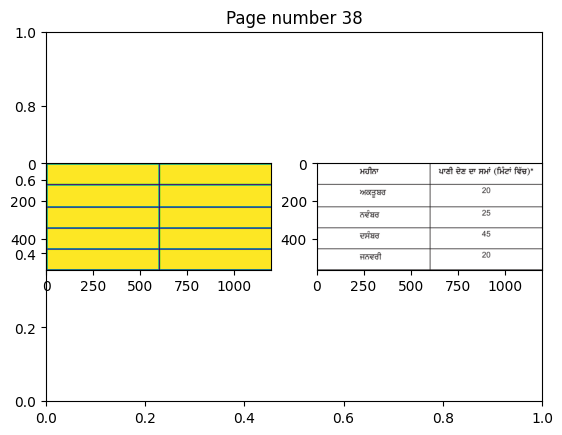

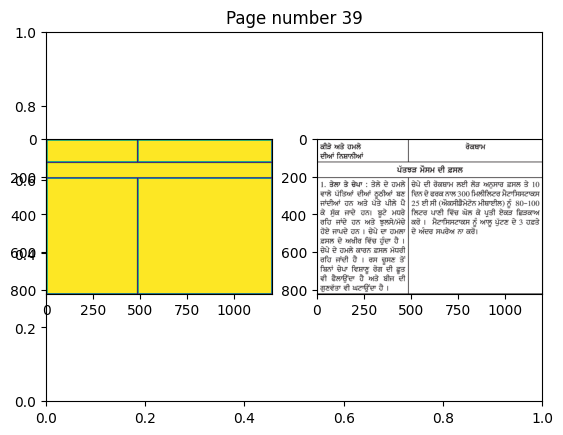

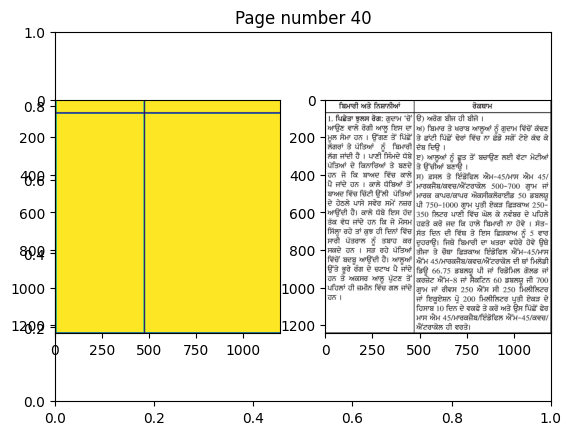

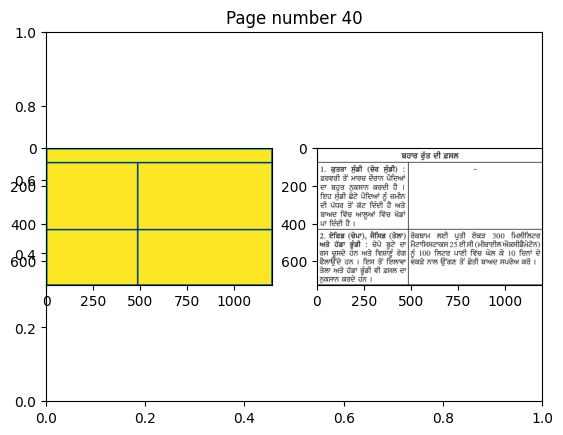

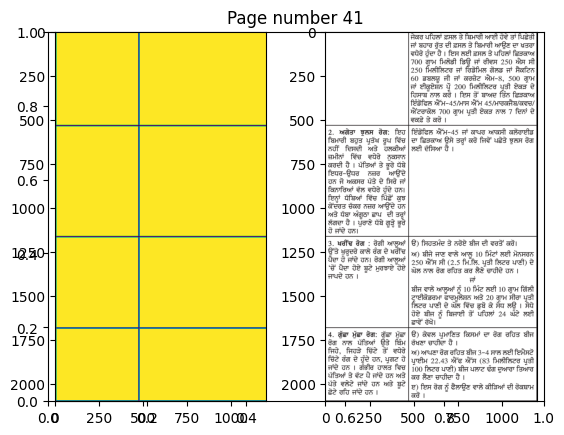

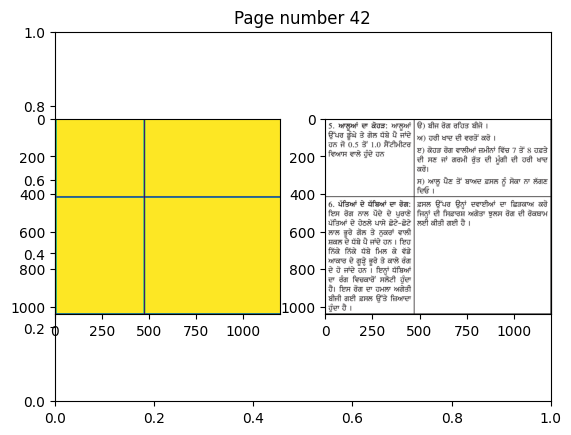

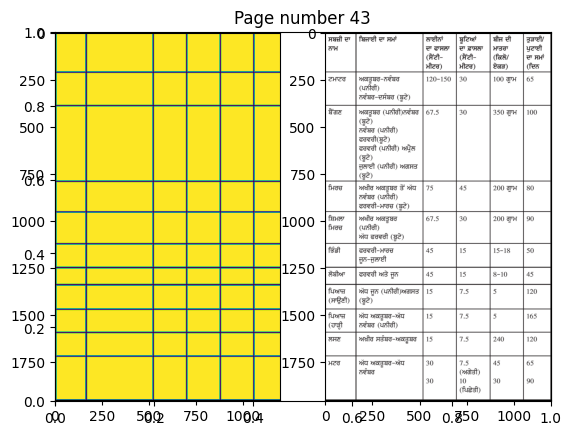

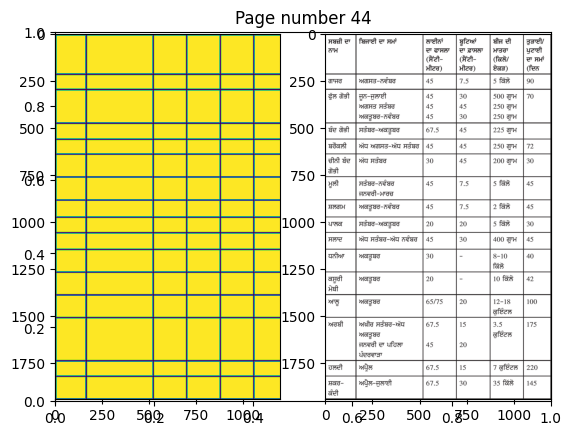

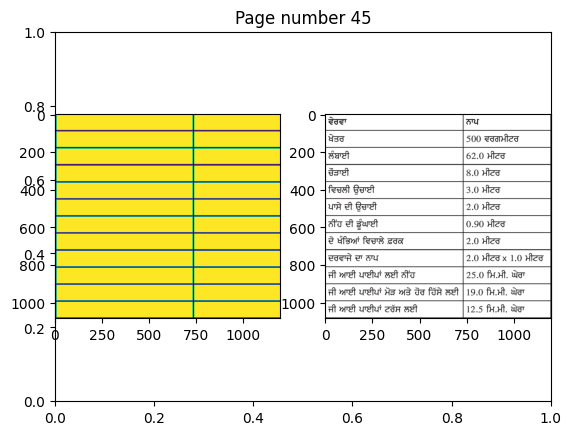

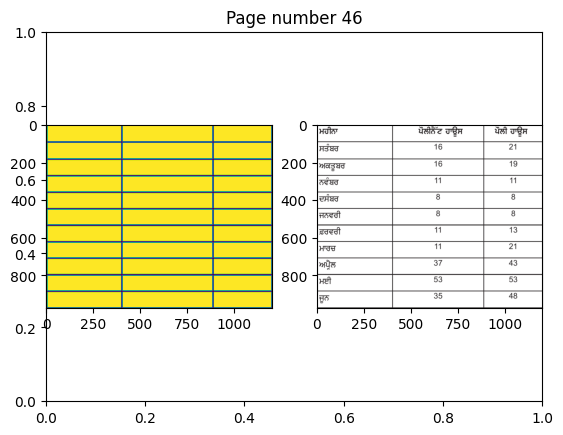

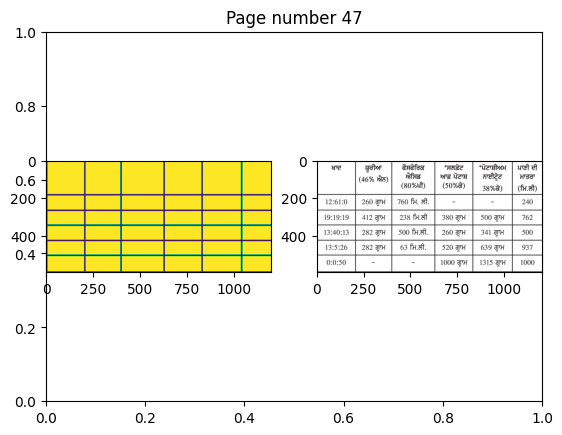

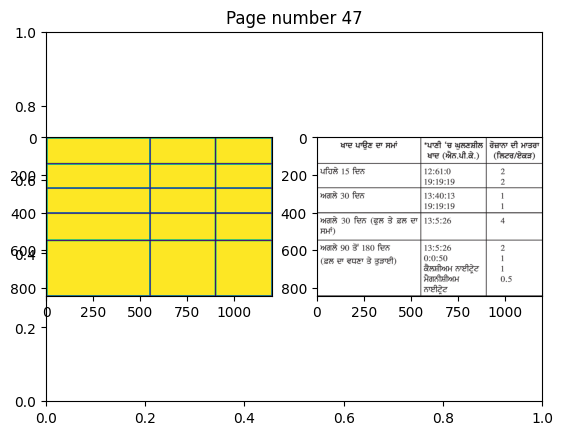

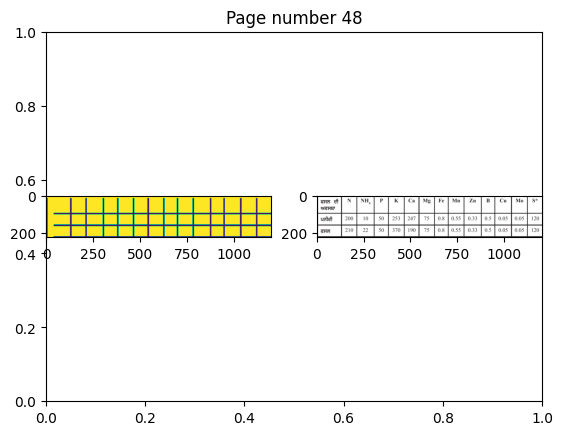

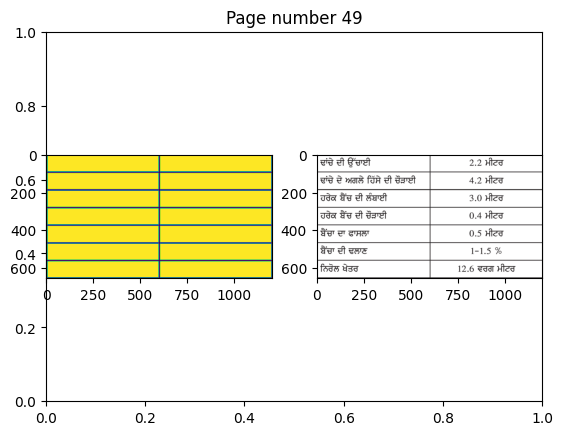

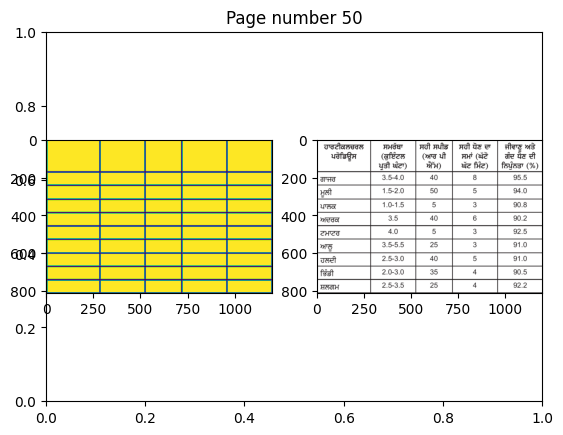

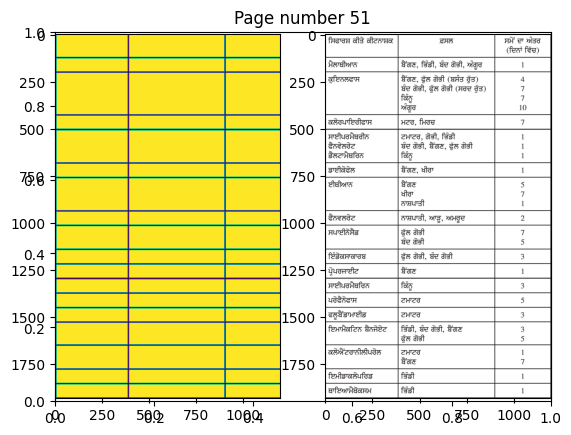

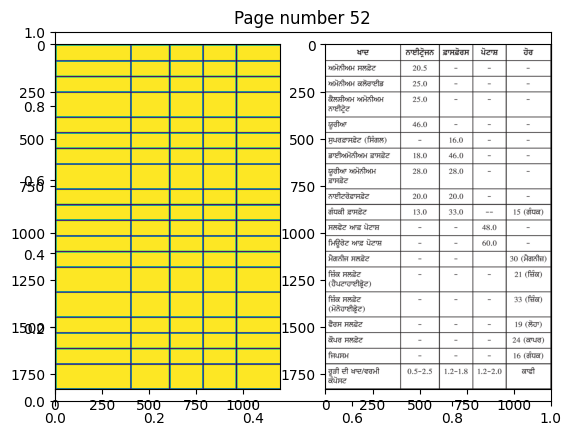

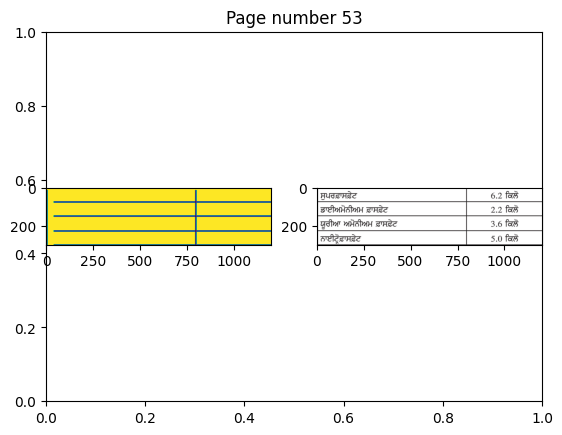

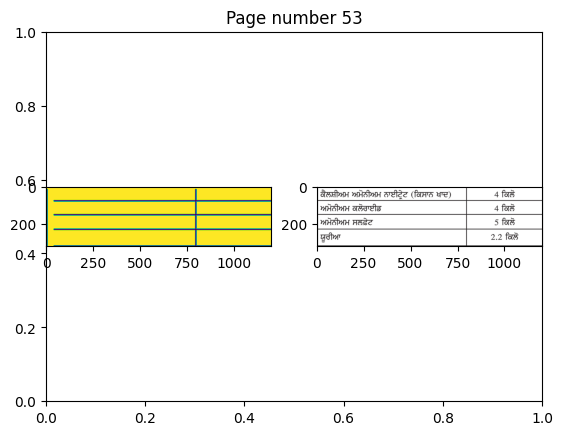

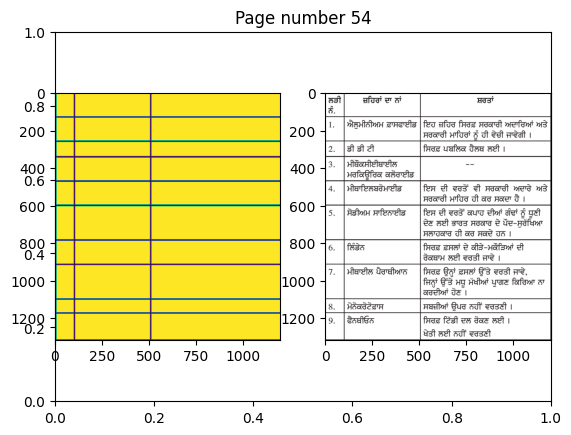

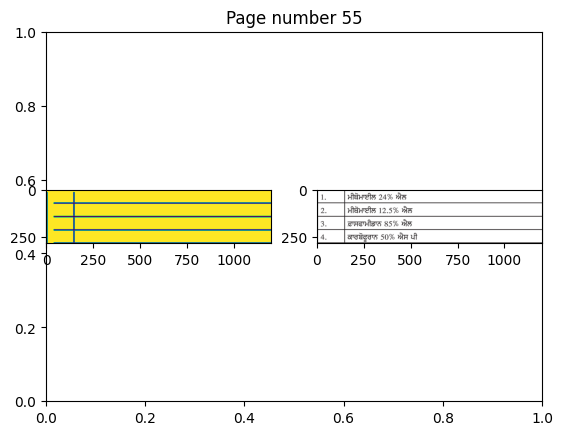

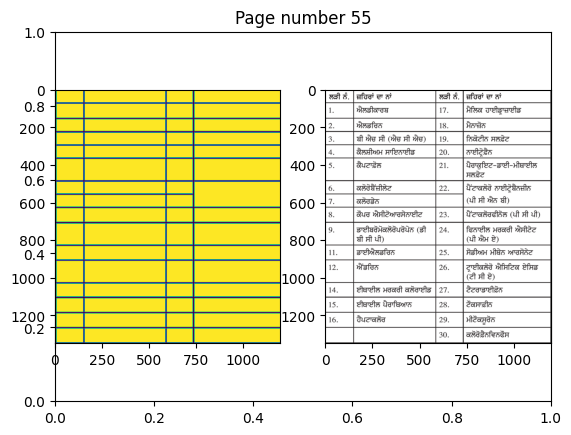

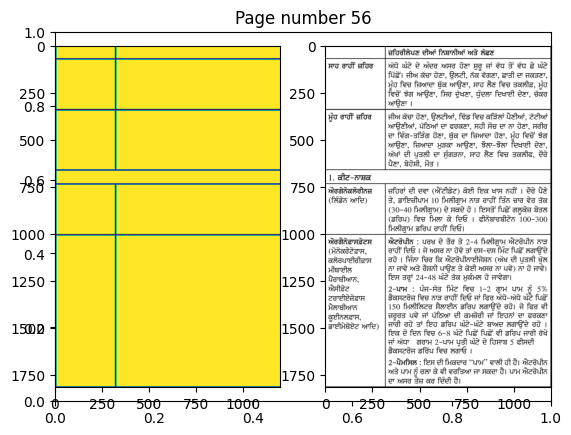

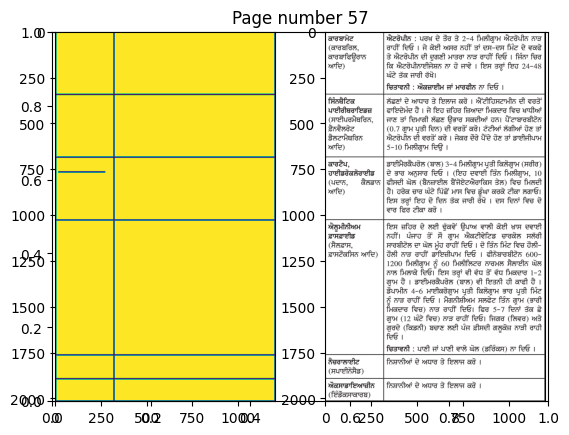

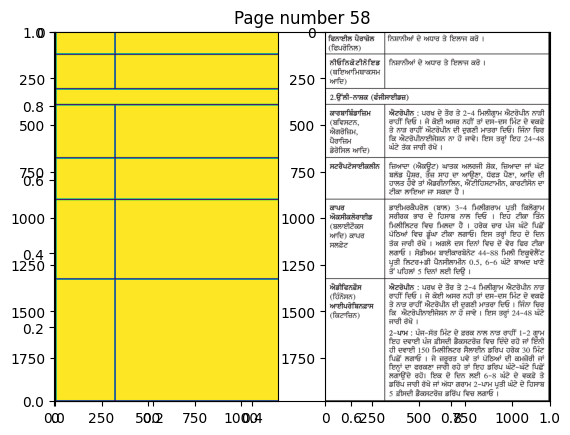

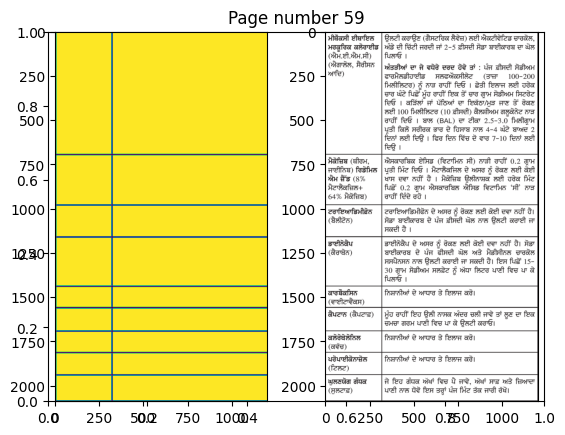

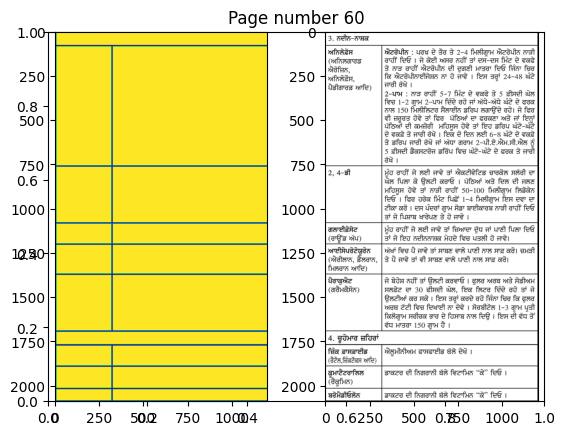

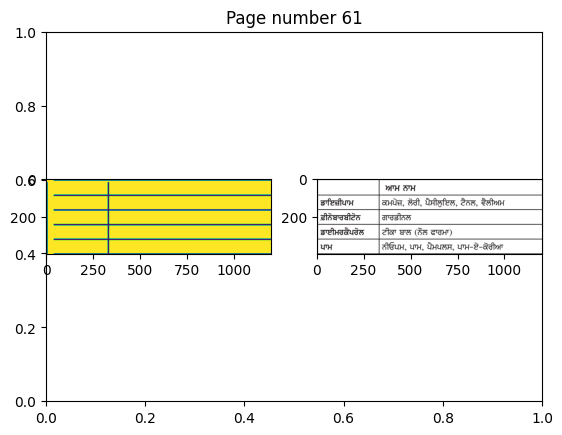

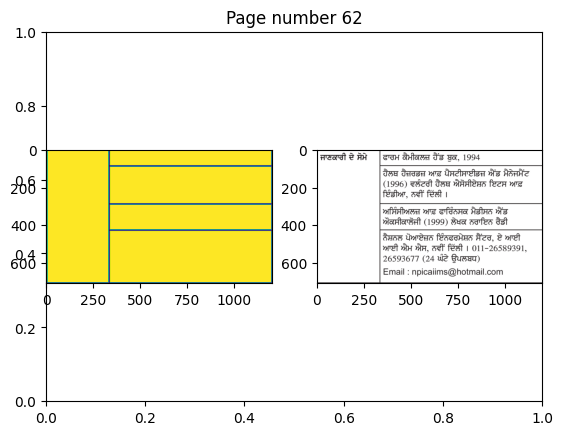

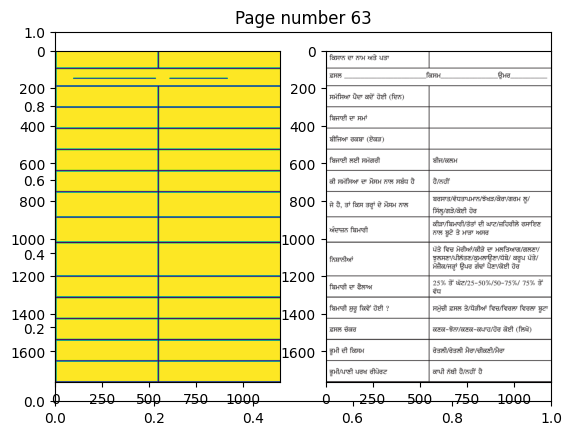

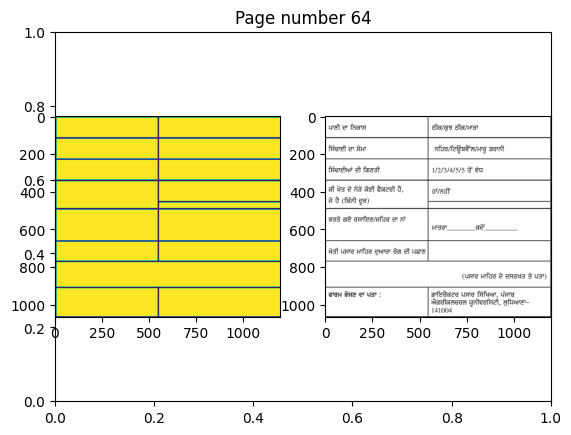

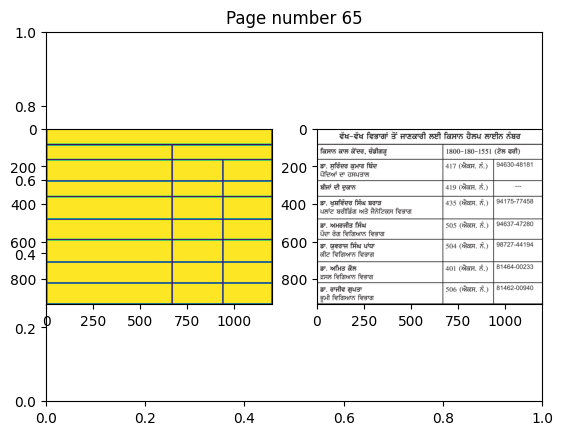

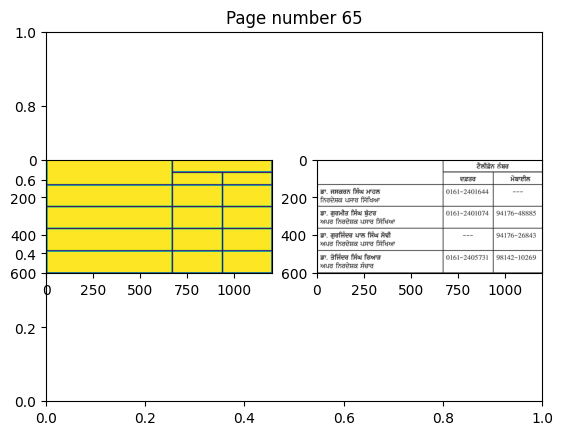

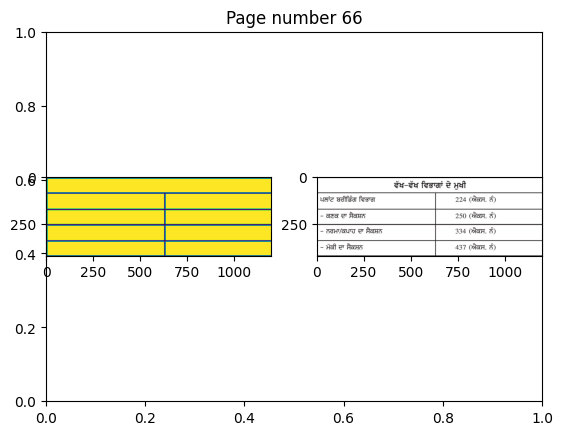

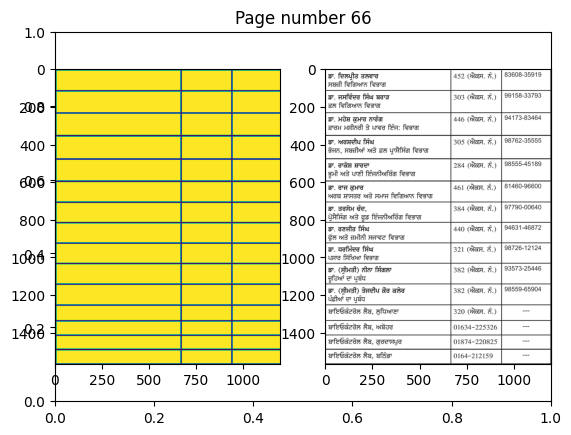

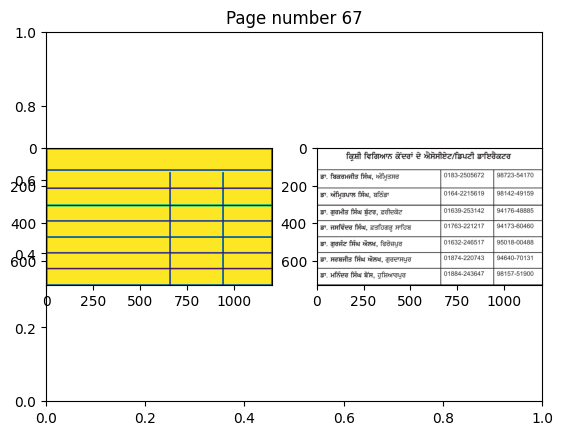

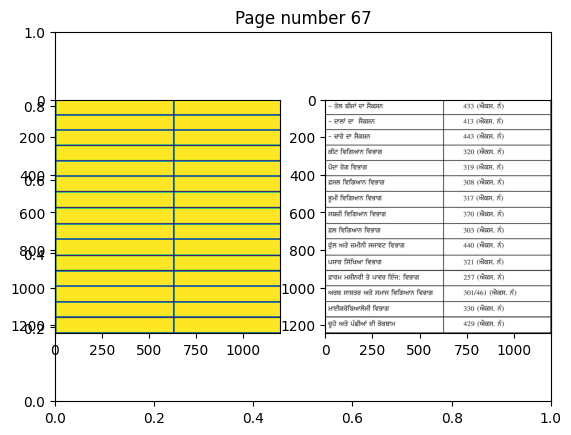

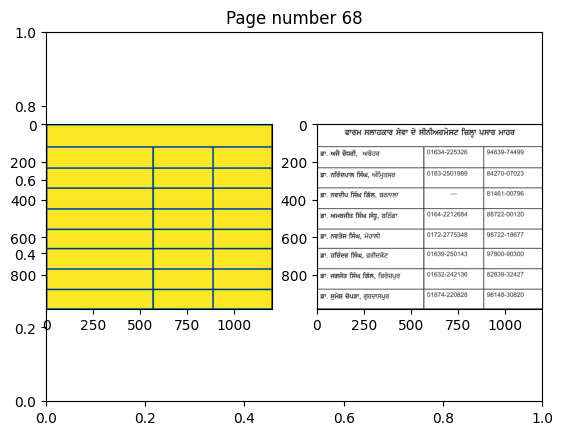

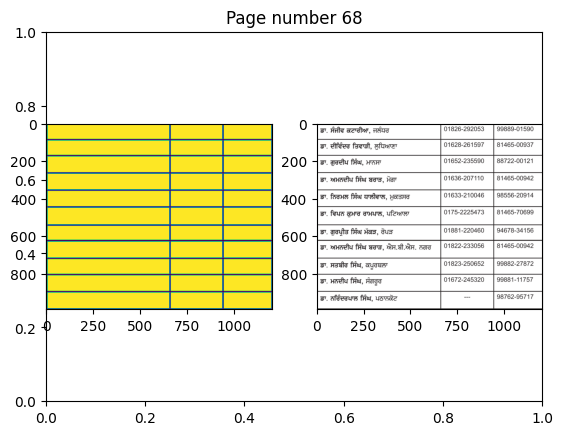

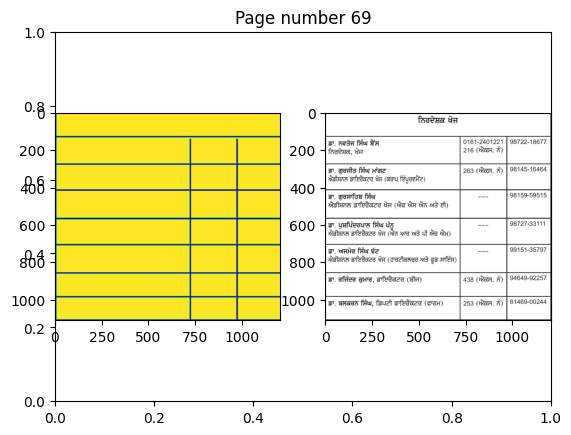

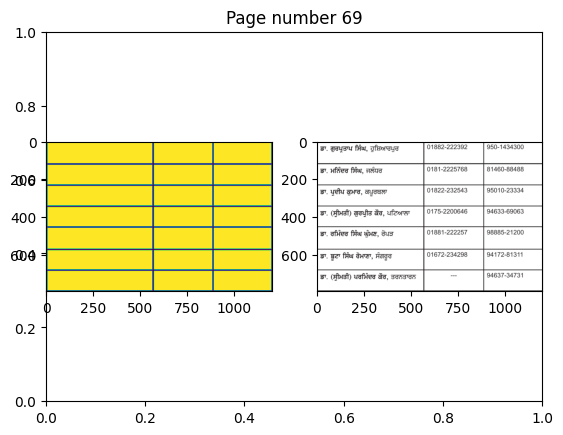

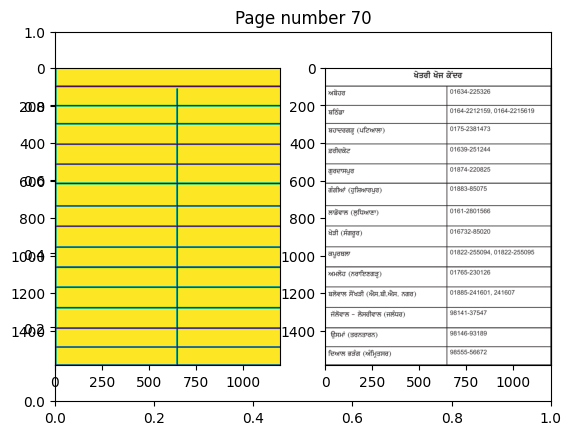

In [24]:
for idx,page in enumerate(tables):
    for table in page:
        plt.title(f'Page number {idx}')
        plt.subplot(121)
        plt.imshow(get_cells_coordinates(table))

        plt.subplot(122)
        plt.imshow(table)

        plt.show()

In [26]:
all_text = ''
for idx,table in enumerate(tables):
    all_text = all_text + f'page-{idx}\n'
#     print(len(table))
    for curr in table:
        try:
            bounding_boxes = get_cells_coordinates_include_verification(curr)
            ocr = get_text_csv(bounding_boxes,curr)
            all_text = all_text + ocr + '\n'
            print(ocr)
        except:
            continue
    all_text = all_text + '\n\n\n\n'

(281, 126) (1205, 1407)
ਸਬਜ਼ੀ,ਰਕਬਾ(ਹਜ਼ਾਰ ਹੈਕਟੇਅਰ),ਔਸਤ ਝਾੜ(ਕੁਇੰਟਲ/ਹੈਕਟੇਅਰ),ਪੈਦਾਵਾਰ(ਹਜ਼ਾਰ ਟਨ),
ਆਲੂ,107.09,275.34,2948.55,
ਮਟਰ,43.89,106.41,467.01,
ਸਬਜ਼ੀਆਂ,28.07,249.27,699.61,
ਵੇਲਾਂ ਵਾਲੀਆਂਸਬਜ਼ੀਆਂ,16.01,195.09,351.27,
ਫੁੱਲ ਗੋਭੀ,22.98,196.12,450.60,
ਪਿਆਜ਼,10.35,238.27,246.52,
ਵਮਾਟਰ,10.28,259.74,266.91,
ਮਿਰਚ,8.78,20.09,17.63,
ਲਸਣ,8.87,109.10,96.77,
ਬੰਦ ਗੋਭੀ,7.98,161.68,129.01,
ਖਰਬੂਜ਼ਾ,7.01,194.87,136.62.,
ਬੈਂਗਣ,5.47,225.72,139.79,
ਭਿੰਡੀ,5.31,103.44,54.88,
,2.19,180.84,38.30,
ਹੋਰ ਸਬਜ਼ੀਆਂ,19.22,34.39,66.09,
ਕੁੱਲ,305.5,,6109.56,

(368, 113) (1206, 1248)
ਕੀੜੇ ਅਤੇ ਹਮਲੇ ਦੀਆਂਨਿਸ਼ਾਨੀਆਂ,ਰੋਕਥਾਮ,ਸਾਵਧਾਨੀਆਂ,
1. ਲਾਲ ਭੂੰਡੀ : ਜਦੋਂਹੀ ਹੁੰਦੇ ਹਨ ਤਾਂ ਲਾਲਭੂੰਡੀ ਇਨ੍ਹਾਂ ਤੇ ਹਮਲਾਕਰਦੀ ਹੈ। ਜ਼ਿਆਦਾਹਮਲਾ ਹੋਣ ਤੇ ਫ਼ਸਲਬਿਲਕੁਲ ਤਬਾਹ ਹੋਜਾਂਦੀ ਹੈ।,ਨਵੇਂ ਜੰਮੇ ਬੂਟਿਆਂ ਦੇ ਪੱਤਿਆਂਉੱਪਰ ਗੋਹੇ ਦੀ ਸਵਾਹ ਦਾ 3-4ਵਾਰ ਹਫਤੇ ਦੇ ਵਕਫੇ ਤੇ ਧੂੜਾਦਿਓ।,ਇਸ ਕੀੜੇ ਦੇ ਹਮਲੇ ਤੋਂਬਚਣ ਲਈ ਫ਼ਸਲ ਨਵੰਬਰਵਿੱਚ ਹੀ ਬੀਜੋ ।,
2. ਚੇਪਾ : ਇਸ ਦਾਹਮਲਾ ਫ਼ਰਵਰੀ ਤੋਂਮਾਰਚ ਤੱਕ ਹੁੰਦਾ ਹੈ।ਇਹ ਪੌਤਿਆਂ ਤੋਂ ਰਸਚੂਸ ਲੈਂਦਾ ਹੈ । ਤੇਲਾਕਈ ਵਿਸ਼ਾਣੂੰ ਰੋਗ ਵੀਫੈਲਾਉਂਦਾ ਹੈ।,,,
3. ਚਿੱਟੀ ਮੌਖੀ : ਇਸਦੇਦਾ ਰਸ ਚੂਸਦੇ ਹਨ ਅਤੇਝਾੜ

(371, 114) (1199, 1864)
ਕੀੜੇ ਅਤੇ ਹਮਲੇ ਦੀਆਂਨਿਸ਼ਾਨੀਆਂ,ਰੋਕਥਾਮ ਦੇ ਢੰਗ,ਸਾਵਧਾਨੀਆਂ,
1. ਜੈਸਿਡ (ਤੇਲਾ), ਹੱਡਾਵਿਚ ਮੋਰੀ ਕਰਨ ਵਾਲੀਸੁੰਡੀ: ਇਹ ਕੀੜੇ ਮਈ ਤੋਂਸਤੰਬਰ ਤੱਕ ਹਮਲਾ ਕਰਦੇਹਨ। ਜੈਸਿਡ ਦੇ ਹਮਲੇ ਕਾਰਨਪੌਤੇ ਪਹਿਲਾਂ ਪੀਲੇ ਤੇ ਪਿਛੋਂਤਾਂਬੇ ਰੰਗ ਦੇ ਹੋ ਕੇ ਝੜ ਜਾਂਦੇਹਨ । ਬੌਚੇ ਅਤੇ ਬਾਲਗ ਹਰੇਰੰਗ ਦੇ ਕੀੜੇ ਬਹੁਤ ਗਿਣਤੀਵਿਚ ਪੌਤਿਆਂ ਦੇ ਹੇਠਾਂ ਨਜ਼ਰਆਉਂਦੇ ਹਨ।ਹੱਡਾ ਭੂੰਡੀ ਅਤੇ ਇਸਨੂੰ ਖਾਂਦੀਆਂ ਹਨ । ਜਿਨ੍ਹਾਂਲਗਰਾਂ ਵਿਚ ਸੁੰਡੀ ਦਾਹਮਲਾ ਹੋਇਆ ਹੋਵੇ ਉਹਮੁਰਝਾ ਕੇ ਡਿੱਗ ਪੈਂਦੀਆਂਹਨ ਜਾਂ ਝੁੱਕ ਜਾਂਦੀਆਂ ਹਨਅਤੇ ਸੁੱਕ ਜਾਂਦੀਆਂ ਹਨਅਤੇ ਫ਼ਲ ਕਾਣੇ ਹੋ ਜਾਂਦੇਹਨ ।,ਬੈਂਗਣ ਦੇ ਫ਼ਲ ਅਤੇ ਲਗਰਾਂ ਵਿਚਮੋਰੀਆਂ ਕਰਨ ਵਾਲੀ ਸੁੰਡੀ ਦੀਰੋਕਥਾਮ ਲਈ, ਜਿਉਂ ਹੀ ਕੀੜੇਦਾ ਹਮਲਾ ਹੋਵੇ,ਹੇਠ ਲਿਖੀਆਂਦਵਾਈਆਂ ਵਿਚੋਂ ਕੋਈ ਇਕਜ਼ਹਿਰ 100-125 ਲਿਟਰ ਪਾਣੀਵਿਚ ਘੋਲ ਕੇ ਪੁਤੀ ਏਕੜ ਦੇਹਿਸਾਬ 3-4 ਵਾਰੀ 14 ਦਿਨਾਂ ਦੇਵਕਫੇ ਨਾਲ ਛਿੜਕੋ।1) 80 ਮਿਲੀਲਿਟਰਕੋਰਾਜ਼ਨ 18.5 ਐਸ ਸੀ(ਕਲੋਰਐਂਟਰਾਨੀਲੀਪਰੋਲ)।) 80 ਗ੍ਰਾਮ ਪ੍ਰੋਕਲੇਮ 5 ਐਸ ਜੀ(ਐਮਾਮੈਕਟਿਨ ਬੈਂਜੋਏਟ)॥) 100 ਮਿਲੀਲਿਟਰਸੁਮੀਸੀਡੀਨ 20 ਈ ਸੀ(ਫੈਨਵਲਰੇਟ)1੪) 200 ਮਿਲੀਲਿਟਰਰਿਪਕਾਰਡ 10 ਈ ਸੀ(ਸਾਈਪਰਮੈਥਰਿਨ)।੪) 160 ਮਿਲੀਲਿਟਰ ਡੈਸਿਸ2.8 ਈ ਸੀ (ਤੈਲਟਾਮੈਥਰਿਨ) ।,ਉ) ਛਿੜਕਾਅ ਕਰਨ ਤੋਂਲਵੋ।ਅ) ਕਾਣੇ ਫ਼ਲ ਤੋੜ ਕੇਜ਼ਮੀਨ ਵਿਚ ਦਬਾ ਦਿਉ ।ਏ) ਬੈਂਗਣਾਂ ਦੀ ਮੋਢੀ ਫ਼ਸਲਨਾ ਰੌਖੋ ।ਸ) ਬੈਂਗਣ

2. ਚਿੱਟੀ ਮੌਖੀ: ਚਿੱਟੀਮੌਖੀ ਦੇ ਬਾਲਗ ਅਤੇਬੌਚੇ ਭਿੰਡੀ ਦੇ ਪੌਤਿਆਂਦਾ ਰਸ ਚੂਸਦੇ ਹਨ ਅਤੇਪੌਤਿਆਂ ਉੱਤੇ ਸ਼ਹਿਦ ਦੇਤੁਪਕਿਆਂ ਵਰਗਾ ਮਲਕੌਂਢਦੇ ਹਨ ਜੋ ਚਿਪਚਿਪਾਜਿਹਾ ਹੁੰਦਾ ਹੈ। ਇਸਉੱਲੀ ਪੈਦਾ ਹੋ ਜਾਂਦੀ ਹੈਤੇ ਇਹ ਕਾਲੇ ਰੰਗ ਦੇ ਹੋਜਾਂਦੇ ਹਨ। ਚਿੱਟੀ ਮੌਖੀਵੀ ਫੈਲਾਉਂਦੀ ਹੈ।,ਰੋਕਥਾਮ ਲਈ 80 ਮਿਲੀਲਿਟਰਇਕੋਟਿਨ 5% (ਨਿੰਮ ਅਧਾਰਿਤਕੀਟਨਾਸ਼ਕ)  ਜਾਂ 2000ਮਿਲੀਲਿਟਰ "ਪੀ.ਏ.ਯੂ. ਨਿੰਮ ਦਾਘੋਲ ਦਾ ਛਿੜਕਾਅ 100-125ਲਿਟਰ ਪਾਣੀ ਵਿੱਚ ਘੋਲ ਕੇ ਪ੍ਰਤੀਏਕੜ ਕਰੋਂ।“"ਪੀ.ਏ.ਯੂ. ਨਿੰਮ ਦਾ ਘੋਲ ਤਿਆਰਕਰਨ ਦੀ ਵਿਧੀ: ਚਾਰ ਕਿਲੋ ਨਿੰਮਦੀਆਂ ਕਰੂੰਬਲਾਂ (ਪੌਤੇ, ਹਰੀਆਂਟਹਿਣੀਆਂ ਅਤੇ ਨਿਮੋਲੀਆਂ)ਨੂੰ 10 ਲਿਟਰ ਪਾਣੀ ਵਿੱਚ 30ਮਿੰਟ ਲਈ ਉਬਾਲੋ। ਇਸ ਘੋਲਨੂੰ ਕੌਪੜ ਛਾਣ ਕਰ ਲਓ ਅਤੇਤਰਲ ਨੂੰ ਸਿਫਾਰਸ਼ ਕੀਤੀ ਮਾਤਰਾਮੁਤਾਬਿਕ ਛਿੜਕਾਅ ਕਰੋ।,ਉ)ਚਿੱਟੀ ਮੌਖੀ ਦੇ ਫੈਲਾਅਸੜਕਾਂ ਦੇ ਕਿਨਾਰਿਆਂ ਅਤੇਚਿੱਟੀ ਮੌਖੀ ਦੇ ਬਦਲਵੇ'ਨਦੀਨਾਂ ਨੂੰ ਨਸ਼ਟ ਕਰੋ।ਅ) ਭਿੰਡੀ ਅਤੇ ਹੋਰ ਫ਼ਸਲਾਂਉੱਪਰ ਚਿੱਟੀ ਮੌਖੀ ਦੇ ਹਮਲੇਦਾ ਲਗਾਤਾਰ ਸਰਵੇਖਣਕਰਦੇ ਰਹੋ।ਏ) ਚਿੱਟੀ ਮੌਖੀ ਦੇ ਵਾਧੇਨੂੰ ਰੋਕਣ ਲਈ ਸਿੰਥੈਟਿਕਪਰਿਥਰਾਇਡ ਕੀਟਨਾਸ਼ਕਾਂਦੀ ਵਰਤੋਂ ਬਿਲਕੁਲ ਨਾਕਰੋਂ।ਸ) ਛਿੜਕਾਅ ਕਰਨ ਤੋਂਤੋੜ ਲਓ।,
3. ਚਿਤਕਬਰੀ ਸੁੰਡੀ;ਇਹ ਕੀੜਾ ਭਿੰਡੀ ਦੀਫ਼ਸਲ ਤੇ ਮਈ ਤੋਸਤੰਬਰ  ਤੱਕ ਹਮਲਾਕਰਦਾ ਹੈ। ਚਿਤਕਬਰੀਸੁੰਡੀ ਦੇ ਹਮਲੇ ਵਾਲੀਆਂਲਗਰਾਂ ਕੁਮਲਾਅਜਾਦੀਆਂ ਹਨ ਅਤੇ ਥੌਲੇਨੂੰ ਡਿੱਗ ਪੈਂਦੀਆਂ ਹਨ।ਚਿਤਕਬਰੀ ਸੁ

3. ਤੰਬਾਕੂ ਦੀ ਸੁੰਡੀ :ਇਹ ਕੀੜਾ ਅਗਸਤ-ਅਕਤੂਬਰ ਵਿੱਚ ਹਮਲਾਕਰਦਾ ਹੈ । ਇਸ ਦਾਹਮਲਾ ਕਦੇ - ਕਦਾਈਂਖਤਰਨਾਕ ਹੁੰਦਾ ਹੈ ।ਜੇਕਰ ਇਸ ਦੀ ਰੋਕਥਾਮਨਾ ਕੀਤੀ ਜਾਵੇ ਤਾਂ ਇਹਮਰੁੰਡ ਦਿੰਦਾ ਹੈ ।ਗਿਣਤੀ ਵਿੱਚ ਇਕੱਠੇ,ਉ) ਇਸ ਦੇ ਆੰਡੇ ਅਤੇ ਸੁੰਡੀਆਂਵਾਲੇ ਪੌਤੇ ਇਕੱਠੇ ਕਰ ਕੇ ਨਸ਼ਟ ਕਰਦਿਉ ।ਅ) ਚਮਕੀਲੀ ਪਿੱਠ ਵਾਲੇ ਪਤੰਗੇ ਦੀਨਾਲ ਇਹ ਸੁੰਡੀਆਂ ਵੀ ਮਰ ਜਾਦੀਆਂਹਨ । ਜੇਕਰ ਇਨ੍ਹਾਂ ਸੁੰਡੀਆਂ ਦਾਹਮਲਾ ਸਾਰੇ ਖੇਤ ਵਿੱਚ ਨਾ ਹੋਵੇ ਤਾਂਇਹ ਜ਼ਹਿਰਾਂ ਹਮਲੇ ਵਾਲੇ ਥਾਵਾਂ ਤੇਹਨ ।,,
ਅ. ਦਰਮਿਆਨੇ ਮੌਸਮ ਦੀ ਫ਼ਸਲ : (ਸਤੰਬਰ-ਦਸੰਬਰ),ਅ. ਦਰਮਿਆਨੇ ਮੌਸਮ ਦੀ ਫ਼ਸਲ : (ਸਤੰਬਰ-ਦਸੰਬਰ),ਅ. ਦਰਮਿਆਨੇ ਮੌਸਮ ਦੀ ਫ਼ਸਲ : (ਸਤੰਬਰ-ਦਸੰਬਰ),
1. ਚਮਕੀਲੀ ਪਿੱਠ ਵਾਲਾ | ਉਪਰ ਦੱਸੇ ਅਨੁਸਾਰ ਅਮਲ ਕਕਰੋਂ । <ਪਤੰਗਾ : ਮੁੱਖ ਫ਼ਸਲ ਤੇਉਪਰ ਦੱਸੇ ਕੀੜੇ ਘੱਟਹੀ ਹਮਲਾ ਕਰਦੇ ਹਨ।ਤੰਬਾਕੂ ਦੀ ਸੁੰਡੀ ਕਈਵਾਰ ਇਸ ਤੇ ਹਮਲਾਕਰਦੀ ਹੈ ਅਤੇ ਇਹਹਮਲਾ ਅਕਤੂਬਰ ਤੱਕਰਹਿੰਦਾ ਹੈ ।,1. ਚਮਕੀਲੀ ਪਿੱਠ ਵਾਲਾ | ਉਪਰ ਦੱਸੇ ਅਨੁਸਾਰ ਅਮਲ ਕਕਰੋਂ । <ਪਤੰਗਾ : ਮੁੱਖ ਫ਼ਸਲ ਤੇਉਪਰ ਦੱਸੇ ਕੀੜੇ ਘੱਟਹੀ ਹਮਲਾ ਕਰਦੇ ਹਨ।ਤੰਬਾਕੂ ਦੀ ਸੁੰਡੀ ਕਈਵਾਰ ਇਸ ਤੇ ਹਮਲਾਕਰਦੀ ਹੈ ਅਤੇ ਇਹਹਮਲਾ ਅਕਤੂਬਰ ਤੱਕਰਹਿੰਦਾ ਹੈ ।,1. ਚਮਕੀਲੀ ਪਿੱਠ ਵਾਲਾ | ਉਪਰ ਦੱਸੇ ਅਨੁਸਾਰ ਅਮਲ ਕਕਰੋਂ । <ਪਤੰਗਾ : ਮੁੱਖ ਫ਼ਸਲ ਤੇਉਪਰ ਦੱਸੇ ਕੀੜੇ ਘੱਟਹੀ ਹਮਲਾ ਕਰਦੇ ਹਨ।ਤੰਬਾਕੂ ਦੀ ਸੁੰਡੀ ਕਈਵਾਰ ਇਸ ਤੇ ਹਮਲਾਕਰਦੀ ਹੈ ਅਤੇ ਇਹਹਮ

5. ਆਲੂਆਂ ਦਾ ਕੋਹੜ: ਆਲੂਆਂਉੱਪਰ ਡੂੰਘੇ ਤੇ ਗੋਲ ਧੱਬੇ ਪੈ ਜਾਂਦੇਹਨ ਜੋ 0.5 ਤੋਂ 1.0 ਸੈਂਟੀਮੀਟਰਵਿਆਸ ਵਾਲੇ ਹੁੰਦੇ ਹਨ,ਉ) ਬੀਜ ਰੋਗ ਰਹਿਤ ਬੀਜੋ ।ਅ) ਹਰੀ ਖਾਦ ਦੀ ਵਰਤੋਂ ਕਰੋ ।ਏ) ਕੋਹੜ ਰੋਗ ਵਾਲੀਆਂ ਜ਼ਮੀਨਾਂ ਵਿੱਚ 7 ਤੋਂ 8 ਹਫ਼ਤੇਦੀ ਸਣ ਜਾਂ ਗਰਮੀ ਰੁੱਤ ਦੀ ਮੂੰਗੀ ਦੀ ਹਰੀ ਖਾਦਕਰੋਂ।ਸ) ਆਲੂ ਪੈਣ ਤੋਂ ਬਾਅਦ ਫ਼ਸਲ ਨੂੰ ਸੋਕਾ ਨਾ ਲੌਂਗਣਦਿਓ ।,
6. ਪੱਤਿਆਂ ਦੇ ਧੱਬਿਆਂ ਦਾ ਰੋਗ:ਇਸ ਰੋਗ ਨਾਲ ਪੌਦੇ ਦੇ ਪੁਰਾਣੇਪੱਤਿਆਂ ਦੇ ਹੇਠਲੇ ਪਾਸੇ ਛੋਟੇ-ਛੋਟੇਲਾਲ ਭੂਰੇ ਗੋਲ ਤੇ ਨੁਕਰਾਂ ਵਾਲੀਸ਼ਕਲ ਦੇ ਧੱਬੇ ਪੈ ਜਾਂਦੇ ਹਨ । ਇਹਨਿੱਕੇ ਨਿੱਕੇ ਧੱਬੇ ਮਿਲ ਕੇ ਵੱਡੇਆਕਾਰ ਦੇ ਗੂੜ੍ਹੇ ਭੂਰੇ ਤੇ ਕਾਲੇ ਰੰਗਦੇ ਹੋ ਜਾਂਦੇ ਹਨ । ਇਨ੍ਹਾਂ ਧੌਬਿਆਂਦਾ ਰੰਗ ਵਿਚਕਾਰੋਂ ਸਲੇਟੀ ਹੁੰਦਾਹੈ। ਇਸ ਰੋਗ ਦਾ ਹਮਲਾ ਅਗੇਤੀਹੁੰਦਾ ਹੈ ।,ਫ਼ਸਲ ਉੱਪਰ ਉਨ੍ਹਾਂ ਦਵਾਈਆਂ ਦਾ ਛਿੜਕਾਅ ਕਰੋਲਈ ਕੀਤੀ ਗਈ ਹੈ ।,

(138, 203) (1199, 1953)
ਸਬਜ਼ੀ ਦਾਨਾਮ,ਬਿਜਾਈ ਦਾ ਸਮਾਂ,ਲਾਈਨਾਂਦਾ ਫਾਸਲਾ(ਸੈਂਟੀ-ਮੀਟਰ),ਬੂਟਿਆਂਦਾ ਫ਼ਾਸਲਾ(ਸੈਂਟੀ-ਮੀਟਰ),ਬੀਜ ਦੀਮਾਤਰਾ(ਕਿਲੋਂ/ਏਕੜ),ਤੁੜਾਈ/ਪੁਟਾਈਦਾ ਸਮਾਂ(ਦਿਨ,
ਟਮਾਟਰ,ਅਕਤੂਬਰ-ਨਵੰਬਰ(ਪਨੀਰੀ)ਨਵੰਬਰ-ਦਸੰਬਰ (ਬੂਟੇ),120-150,30,100 ਗ੍ਰਾਮ,65,
ਬੈਂਗਣ,ਅਕਤੂਬਰ (ਪਨੀਰੀ)ਨਵੰਬਰ(ਬੂਟੇ)ਨਵੰਬਰ (ਪਨੀਰੀ)ਫਰਵਰੀ(ਬੂਟੇ)ਫਰਵਰੀ (ਪਨੀਰੀ) ਅਪ੍ਰੈਲ(ਬੂਟੇ)ਜੁਲਾਈ (ਪਨੀਰੀ) ਅਗਸਤ(ਬੂਟੇ),67.5,30,350 ਗ੍ਰਾਮ,100,
ਮਿਰਚ,ਅਖੀਰ ਅਕਤੂਬਰ ਤੋਂ 

ਕਾਰਬਾਮੇਟ(ਕਾਰਬਰਿਲ,ਕਾਰਬਾਫਿਊਰਾਨਆਦਿ),ਐਟਰੋਪੀਨ : ਪਰਖ਼ ਦੇ ਤੌਰ ਤੇ 2-4 ਮਿਲੀਗ੍ਰਾਮ ਐਟਰੋਪੀਨ ਨਾੜਰਾਹੀਂ ਦਿਓ । ਜੇ ਕੋਈ ਅਸਰ ਨਹੀਂ ਤਾਂ ਦਸ-ਦਸ ਮਿੰਟ ਦੇ ਵਕਫੇਤੇ ਐਟਰੋਪੀਨ ਦੀ ਦੁਗਣੀ ਮਾਤਰਾ ਨਾੜ ਰਾਹੀਂ ਦਿਓ । ਜਿੰਨਾ ਚਿਰਕਿ ਐਟਰੋਪੀਨਾਈਜੇਸ਼ਨ ਨਾ ਹੋ ਜਾਵੇ । ਇਸ ਤਰ੍ਹਾਂ ਇਹ 24-48ਘੰਟੇ ਤੱਕ ਜਾਰੀ ਰੌਖੋ।ਚਿਤਾਵਨੀ : ਔਕਜ਼ਾਈਮ ਜਾਂ ਮਾਰਫੀਨ ਨਾ ਦਿਓ ।,
ਸਿੰਨਥੈਟਿਕਪਾਈਰੀਥਰਾਇਡਜ਼(ਸਾਈਪਰਮੈਥਰਿਨ,ਫ਼ੈਨਵੈਲਰੇਟਡੈਲਟਾਮੈਥਰਿਨਆਦਿ),ਲੱਛਣਾਂ ਦੇ ਆਧਾਰ ਤੇ ਇਲਾਜ ਕਰੋ । ਐਂਟੀਹਿਸਟਾਮੀਨ ਦੀ ਵਰਤੋਫਾਇਦੇਮੰਦ ਹੈ । ਜੇ ਇਹ ਜ਼ਹਿਰ ਜ਼ਿਆਦਾ ਮਿਕਦਾਰ ਵਿਚ ਖਾਧੀਆਂਜਾਣ ਤਾਂ ਦਿਮਾਗੀ ਲੌਛਣ ਉਭਾਰ ਸਕਦੀਆਂ ਹਨ। ਪੈਂਟਾਬਾਰਬੀਟੋਨ(0.7 ਗ੍ਰਾਮ ਪੁਤੀ ਦਿਨ) ਦੀ ਵਰਤੋ' ਕਰੋ। ਟੱਟੀਆਂ ਲੱਗੀਆਂ ਹੋਣ ਤਾਂਐਟਰੋਪੀਨ ਦੀ ਵਰਤੋਂ ਕਰੋ । ਜੇਕਰ ਦੌਰੇ ਪੈਂਦੇ ਹੋਣ ਤਾਂ ਡਾਈਜੀਪਾਮ5-10 ਮਿਲੀਗ੍ਰਾਮ ਦਿਉ ।,
ਕਾਰਟੈਪ,ਪਡਰੋ ਕਲੋਰਾਈ(ਪਦਾਨ, ਕੈਲਡਾਨਆਦਿ),ਡਾਈਮੈਰਕੈਪਰੋਲ (ਬਾਲ) 3-4 ਮਿਲੀਗ੍ਰਾਮ ਪੁਤੀ ਕਿਲੋਗ੍ਰਾਮ (ਸਰੀਰ)ਦੇ ਭਾਰ ਅਨੁਸਾਰ ਦਿਓ । (ਇਹ ਦਵਾਈ ਤਿੰਨ ਮਿਲੀਗ੍ਰਾਮ, 10ਫੀਸਦੀ ਘੋਲ (ਬੈਨਜ਼ਾਈਲ ਬੈਂਜੋਏਟਐਰਾਕਿਸ ਤੇਲ) ਵਿਚ ਮਿਲਦੀਹੈ। ਹਰੇਕ ਚਾਰ ਘੰਟੇ ਪਿੱਛੋਂ ਮਾਸ ਵਿਚ ਡੂੰਘਾ ਕਰਕੇ ਟੀਕਾ ਲਗਾਓ।ਇਸ ਤਰ੍ਹਾਂ ਇਹ ਦੋ ਦਿਨ ਤੱਕ ਜਾਰੀ ਰੱਖੋ । ਦਸ ਦਿਨਾਂ ਵਿਚ ਦੋਵਾਰ ਫਿਰ ਟੀਕਾ ਕਰੋ ।,
ਐਲੂਮੀਨੀਅਮਫ਼ਾਸਫ਼ਾਈਡ(ਸੈਲਫ਼ਾਸ,ਫ਼ਾਸਟੌਕਸਿਨ ਆਦਿ),ਇਸ ਜ਼ਹਿਰ ਦੇ ਲਈ 

ਪਾਣੀ ਦਾ ਨਿਕਾਸ,ਠੀਕ/ਕੁਝ ਠੀਕ/ਮਾੜਾ,
ਸਿੰਚਾਈ ਦਾ ਸੋਮਾ,ਨਹਿਰ/ਟਿਊਬਵੈੱਲ/ਮਾਰੂ ਬਰਾਨੀ,
ਸਿੰਚਾਈਆਂ ਦੀ ਗਿਣਤੀ,1/2/3/4/5/5 ਤੋਂ' ਵੱਧ,
ਕੀ ਖੇਤ ਦੇ ਨੇੜੇ ਕੋਈ ਫੈਕਟਰੀ ਹੈ,ਜੇ ਹੈ (ਕਿੰਨੀ ਦੂਰ),ਹਾਂ/ਨਹੀਂ,
ਕੀ ਖੇਤ ਦੇ ਨੇੜੇ ਕੋਈ ਫੈਕਟਰੀ ਹੈ,ਜੇ ਹੈ (ਕਿੰਨੀ ਦੂਰ),,
ਵਰਤੇ ਗਏ ਰਸਾਇਣ/ਜ਼ਹਿਰ ਦਾ ਨਾਂ,ਮਾਤਰਾ ਕਦੋਂ,
ਖੇਤੀ ਪਸਾਰ ਮਾਹਿਰ ਦੁਆਰਾ ਰੋਗ ਦੀ ਪਛਾਣ,,
(ਪਸਾਰ ਮਾਹਿਰ ਦੇ ਦਸਤਖਤ ਤੇ ਪਤਾ),(ਪਸਾਰ ਮਾਹਿਰ ਦੇ ਦਸਤਖਤ ਤੇ ਪਤਾ),
ਫਾਰਮ ਭੇਜਣ ਦਾ ਪਤਾ :,ਐਗਰੀਕਲਚਰਲ ਯੂਨੀਵਰਸਿਟੀ, ਲੁਧਿਆਣਾ-141004,

(1189, 77) (1199, 933)
ਵੱਖ-ਵੱਖ ਵਿਭਾਗਾਂ ਤੋਂ ਜਾਣਕਾਰੀ ਲਈ ਕਿਸਾਨ ਹੈਲਪ ਲਾਈਨ ਨੰਬਰ,ਵੱਖ-ਵੱਖ ਵਿਭਾਗਾਂ ਤੋਂ ਜਾਣਕਾਰੀ ਲਈ ਕਿਸਾਨ ਹੈਲਪ ਲਾਈਨ ਨੰਬਰ,ਵੱਖ-ਵੱਖ ਵਿਭਾਗਾਂ ਤੋਂ ਜਾਣਕਾਰੀ ਲਈ ਕਿਸਾਨ ਹੈਲਪ ਲਾਈਨ ਨੰਬਰ,
,1800-180-1551 (ਟੋਲ ਫਰੀ),1800-180-1551 (ਟੋਲ ਫਰੀ),
ਡਾ. ਸੁਰਿੰਦਰ ਕੁਮਾਰ ਥਿੰਦਪੌਦਿਆਂ ਦਾ ਹਸਪਤਾਲ,417 (ਐਕਸ. ਨੰ.),94630-48181,
ਬੀਜਾਂ ਦੀ ਦੁਕਾਨ,419 (ਐਕਸ. ਨੰ.),,
ਡਾ. ਖੁਸ਼ਵਿੰਦਰ ਸਿੰਘ ਬਰਾੜਪਲਾਂਟ ਬਰੀਡਿੰਗ ਅਤੇ ਜੈਨੇਟਿਕਸ ਵਿਭਾਗ,435 (ਐਕਸ. ਨੰ.),94175-77458,
ਡਾ. ਅਮਰਜੀਤ ਸਿੰਘਪੌਦਾ ਰੋਗ ਵਿਗਿਆਨ ਵਿਭਾਗ,505 (ਐਕਸ. ਨੰ.),94637-47280,
ਡਾ. ਯੁਵਰਾਜ ਸਿੰਘ ਪਾਂਧਾਕੀਟ ਵਿਗਿਆਨ ਵਿਭਾਗ,504 (ਐਕਸ. ਨੰ.),98727-44194,
ਡਾ. ਅਮਿਤ ਕੌਲਫ਼ਸਲ ਵਿਗਿਆਨ ਵਿਭਾਗ,401 (ਐਕਸ. ਨੰ.),

In [29]:
output_file = 'data_books/ocr_punjabi/pp_vegs_tables.txt'
f=open(output_file,'w')
f.write(all_text)
f.close()

In [30]:
problem = [15,16,17,24,28,36,48,53,55,61]

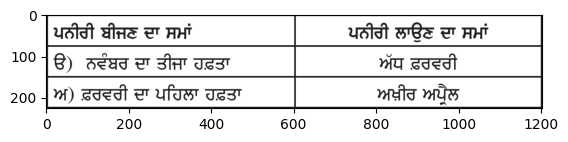

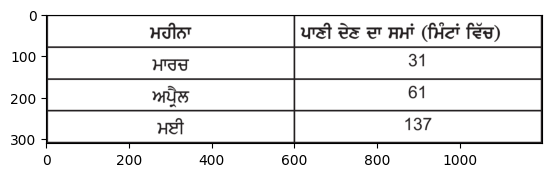

[ਮਹੀਨਾ _______ਪਾਣੀ ਦੇਣ ਦਾ ਸਾਂ (ਮਿੰਟਾਂ ਵਿੱਚ)

 



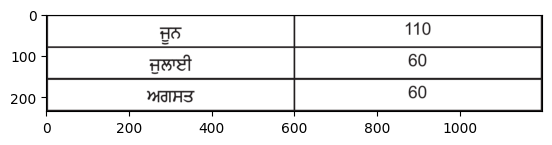

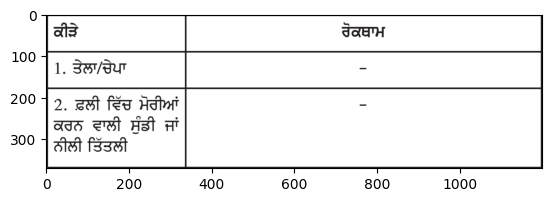

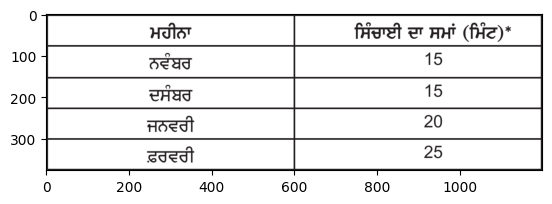

ਸਿੰਚਾਈ ਦਾ ਸਮਾਂ (ਮਿਟ)”
____ ਨਵੰਬਰ | £

[_____ ਦਸੰਬਰ
[_____ ਜਨਵਰੀ

 



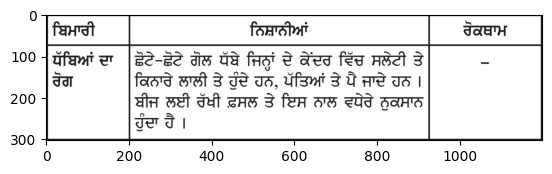

ਛੋਟੇ-ਛੋਟੇ ਗੋਲ ਧੱਬੇ ਜਿਨ੍ਹਾਂ ਦੇ ਕੇਂਦਰ ਵਿੱਚ ਸਲੇਟੀ ਤੇ

ਕਿਨਾਰੇ ਲਾਲੀ ਤੇ ਹੁੰਦੇ ਹਨ, ਪੌਤਿਆਂ ਤੇ ਪੈ ਜਾਦੇ ਹਨ ।
ਬੀਜ ਲਈ ਰੱਖੀ ਫ਼ਸਲ ਤੇ ਇਸ ਨਾਲ ਵਧੇਰੇ ਨੁਕਸਾਨ
ਹੁੰਦਾ ਹੈ ।

 



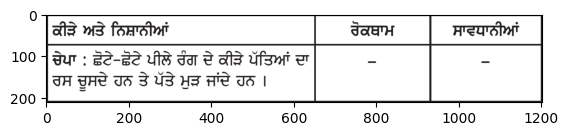

ਚੇਪਾ : ਛੋਟੇ-ਛੋਟੇ ਪੀਲੇ ਰੰਗ ਦੇ ਕੀੜੇ ਪੌਤਿਆਂ ਦਾ
ਰਸ ਚੂਸਦੇ ਹਨ ਤੇ ਪੌਤੇ ਮੁੜ ਜਾਂਦੇ ਹਨ ।

 



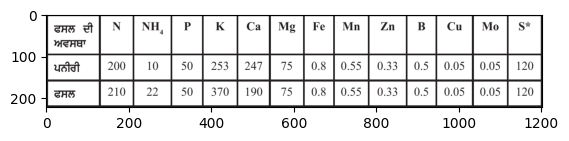

ਫਸਲ ਦੀ [ 3 ਵੀ, । €3੩ | ੮2 | 8੬ | ੧੩ | 29 €ਧ | ੧0 | 5#
ਅਵਸਥਾ

[ਅਜ ਹਜ ਜਜ[ਜ[ਜਨੀਜਨਯ਼ੀਜਨੀਯ਼
੩ [ਅਜ[ਜਯਜਜ਼[ਜ[ਜ਼[ਜ਼[ਜ਼ਲੀਲ਼ੀਜ

 



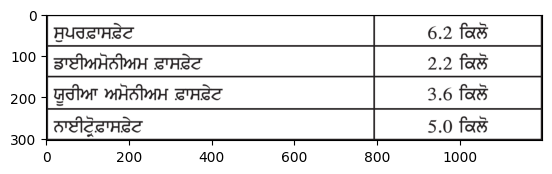

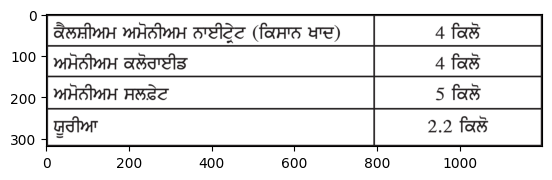

ਕੈਲਸ਼ੀਅਮ ਅਮੋਨੀਅਮ ਨਾਈਟ੍ੇਟ (ਕਿਸਾਨ ਖਾਦ)

ਅਮੋਨੀਅਮ ਕਲੋਰਾਈਡ

 



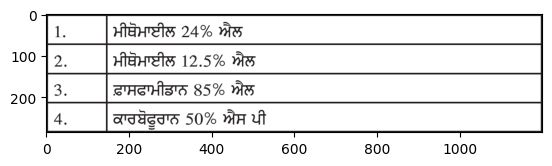

2

 

2]



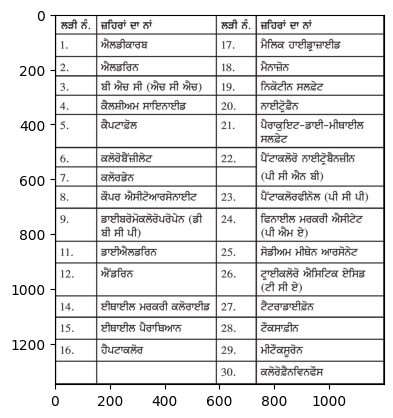

<|॥
੍
ਤੁ
` $|
੩ |
ਹਲ

ਲੇ
`'ਟਿ
( ਤੇ
[00 ਚ
2

8
€੧]॥ €੧] `ਚ [ ੫)

 



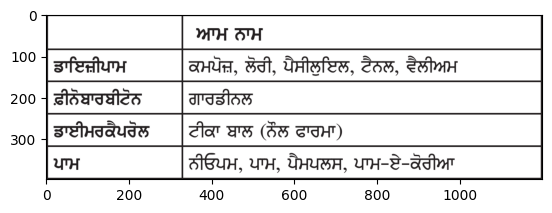

In [32]:
for i in problem:
    for table in tables[i]:
        plt.imshow(table)
        plt.show()
        print(pt.image_to_string(table,lang='pan'))